In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.resnet import ResNet152, preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as mobilenet_preprocess_input
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input as densenet_preprocess_input
from tensorflow.keras.applications.xception import Xception, preprocess_input as xception_preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import warnings
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

2025-05-24 05:00:25.705661: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748062825.892207      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748062825.947294      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Function to plot ROC Curve and AUC
def plot_roc_curve_and_auc(y_true, y_pred, model_name, n_classes):
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='lower right')
    plt.show()

In [5]:
# Define class names
class_names = [
    'Ambassador', 'Autorickshaw', 'Bicycle', 'Bus', 'Car', 'MiniTruck', 'Motorized2wheeler', 'Motorvan', 'Rickshaw', 'Toto', 'Truck', 'Van'
]

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, class_names, title='Confusion Matrix', normalize=False):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
        cmap = 'Blues'
        plt.title(f'{title} (Normalized)')
    else:
        fmt = 'd'
        cmap = 'Oranges'
        plt.title(f'{title} (Raw Counts)')
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Function to plot training and validation accuracy and loss
def plot_training_history(history, model_name):
    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} - Training and Validation Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Function to build and train a model, and print results
def train_model(base_model_class, preprocess_input_function, model_name, class_names):
    if base_model_class is None:
        print(f"{model_name} is not available in this environment.")
        return
    
    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input_function,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )

    validation_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input_function
    )

    # Create generators
    train_generator = train_datagen.flow_from_directory(
        '/kaggle/input/vehicle-cropped/train',
        target_size=(128, 128),
        batch_size=16,
        class_mode='categorical'
    )

    validation_generator = validation_datagen.flow_from_directory(
        '/kaggle/input/vehicle-cropped/test',
        target_size=(128, 128),
        batch_size=16,
        class_mode='categorical',
        shuffle=False
    )

    # Load the base model
    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    
    # Unfreeze the top layers of the base model
    for layer in base_model.layers[-20:]:
        layer.trainable = True
    
    # Build the model
    model = Sequential([
        base_model,
        Flatten(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(len(class_names), activation='softmax')  # Adjust for the number of classes
    ])
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    #reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6)
    model_checkpoint = ModelCheckpoint(f'{model_name}_best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
    
    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        epochs=50,
        callbacks=[early_stopping, model_checkpoint]
    )
    
    # Plot training and validation loss and accuracy
    plot_training_history(history, model_name)
    
    # Predictions
    validation_generator.reset()
    start_time = time.time()
    Y_pred = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
    end_time = time.time()
    t_time = end_time - start_time
    print(f"Prediction time: {t_time} seconds")
    
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = validation_generator.classes
    
    # Classification report and accuracy
    report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    overall_accuracy = accuracy_score(y_true, y_pred)
    overall_precision = report_dict['weighted avg']['precision']
    overall_recall = report_dict['weighted avg']['recall']
    overall_f1_score = report_dict['weighted avg']['f1-score']
    
    print(f"\nModel: {model_name}")
    print(f"Overall Accuracy: {overall_accuracy:.2f}")
    print(f"Overall Precision: {overall_precision:.2f}")
    print(f"Overall Recall: {overall_recall:.2f}")
    print(f"Overall F1-Score: {overall_f1_score:.2f}")
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot raw and normalized confusion matrices
    plot_confusion_matrix(cm, class_names, title=f'{model_name} Confusion Matrix (Raw Counts)', normalize=False)
    plot_confusion_matrix(cm, class_names, title=f'{model_name} Confusion Matrix (Normalized)', normalize=True)
    
    # Convert y_true to one-hot encoding for ROC curve
    y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=len(class_names))

    # ROC Curve and AUC (Function assumed to be defined elsewhere)
    plot_roc_curve_and_auc(y_true_one_hot, Y_pred, model_name, len(class_names))


Found 3901 images belonging to 12 classes.
Found 1323 images belonging to 12 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(
I0000 00:00:1748062977.824904      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1748063020.910409     109 service.cc:148] XLA service 0x7dce2c002280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748063020.911182     109 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748063024.723651     109 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1748063029.775310     109 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748063029.957432     109 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748063030.300109     109 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748063030.4823

  1/243 ━━━━━━━━━━━━━━━━━━━━ 4:17:58 64s/step - accuracy: 0.0625 - loss: 3.5224

I0000 00:00:1748063044.430282     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


180/243 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.4922 - loss: 1.6788

E0000 00:00:1748063077.680371     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748063077.862430     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748063078.192223     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748063078.374666     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748063078.638065     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

243/243 ━━━━━━━━━━━━━━━━━━━━ 135s 294ms/step - accuracy: 0.5386 - loss: 1.5217 - val_accuracy: 0.8399 - val_loss: 0.4725
Epoch 2/50
  1/243 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8750 - loss: 0.6417

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


243/243 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8750 - loss: 0.6417 - val_accuracy: 0.8407 - val_loss: 0.4723
Epoch 3/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 31s 128ms/step - accuracy: 0.8476 - loss: 0.4921 - val_accuracy: 0.8994 - val_loss: 0.3329
Epoch 4/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 1.0000 - loss: 0.0733 - val_accuracy: 0.9002 - val_loss: 0.3318
Epoch 5/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 30s 124ms/step - accuracy: 0.8874 - loss: 0.3547 - val_accuracy: 0.9268 - val_loss: 0.2429
Epoch 6/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8750 - loss: 0.3464 - val_accuracy: 0.9284 - val_loss: 0.2425
Epoch 7/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 31s 127ms/step - accuracy: 0.9085 - loss: 0.2806 - val_accuracy: 0.9398 - val_loss: 0.2149
Epoch 8/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8750 - loss: 0.3259 - val_accuracy: 0.9398 - val_loss: 0.2147
Epoch 9/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 31s 127ms/step - accuracy: 0.9264 - loss: 0.2285 - val_accurac

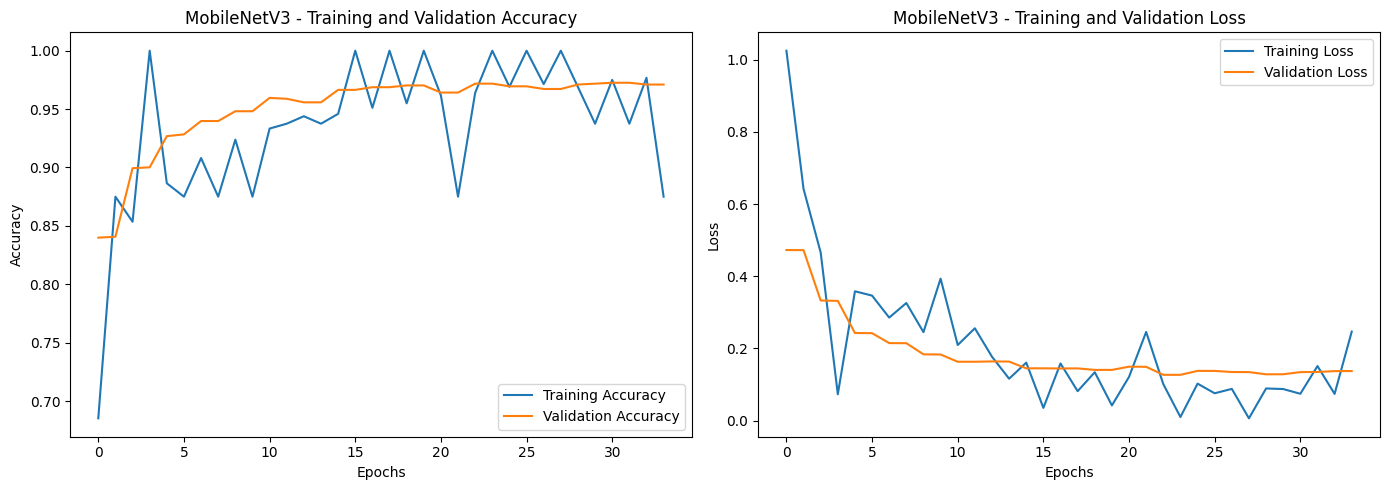

83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 122ms/step
Prediction time: 14.570306062698364 seconds

Model: MobileNetV3
Overall Accuracy: 0.97
Overall Precision: 0.97
Overall Recall: 0.97
Overall F1-Score: 0.97

Classification Report:
                   precision    recall  f1-score   support

       Ambassador       0.99      0.98      0.99       148
     Autorickshaw       0.99      0.99      0.99       182
          Bicycle       1.00      0.93      0.96        44
              Bus       0.99      0.99      0.99       190
              Car       0.98      0.99      0.98       149
        MiniTruck       0.86      0.92      0.89        77
Motorized2wheeler       1.00      0.98      0.99       160
         Motorvan       1.00      1.00      1.00        10
         Rickshaw       0.95      1.00      0.97       154
             Toto       1.00      0.64      0.78        14
            Truck       0.82      0.82      0.82        45
              Van       0.99      0.97      0.98       150

         a

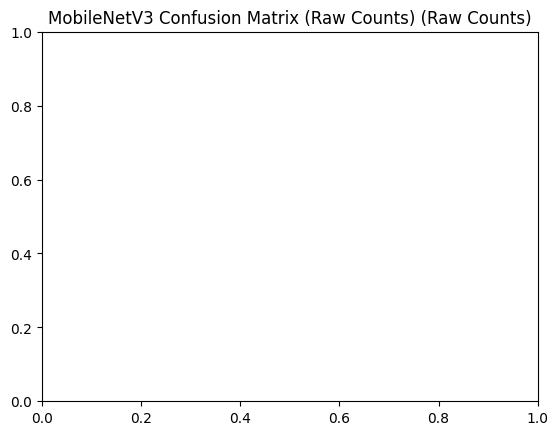

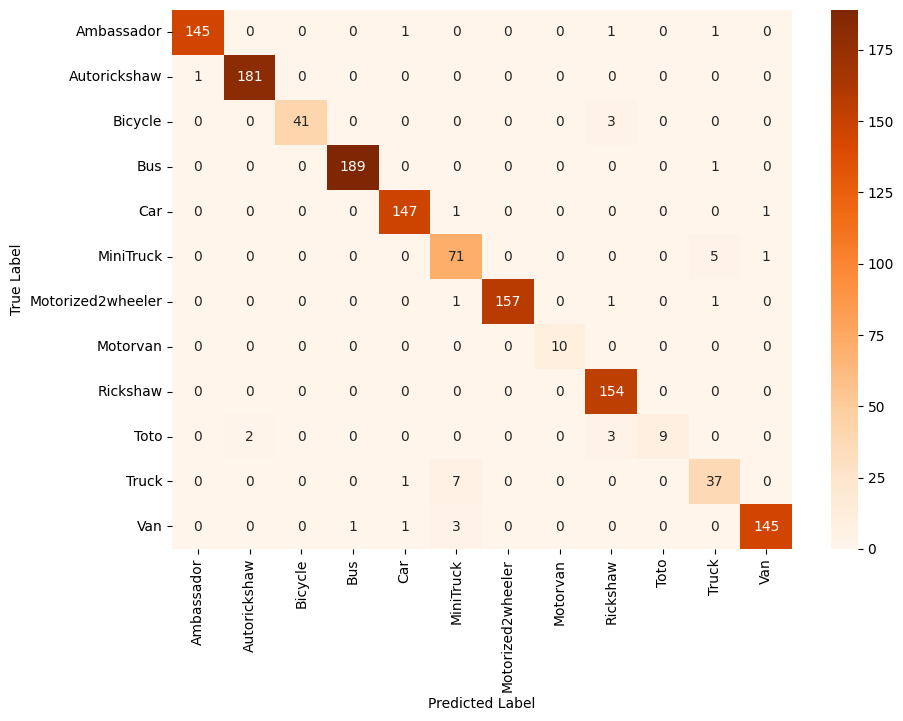

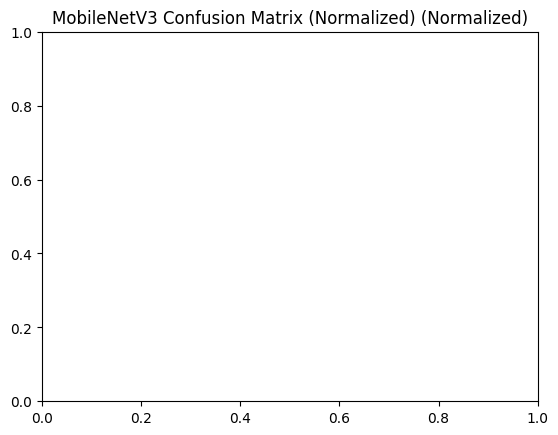

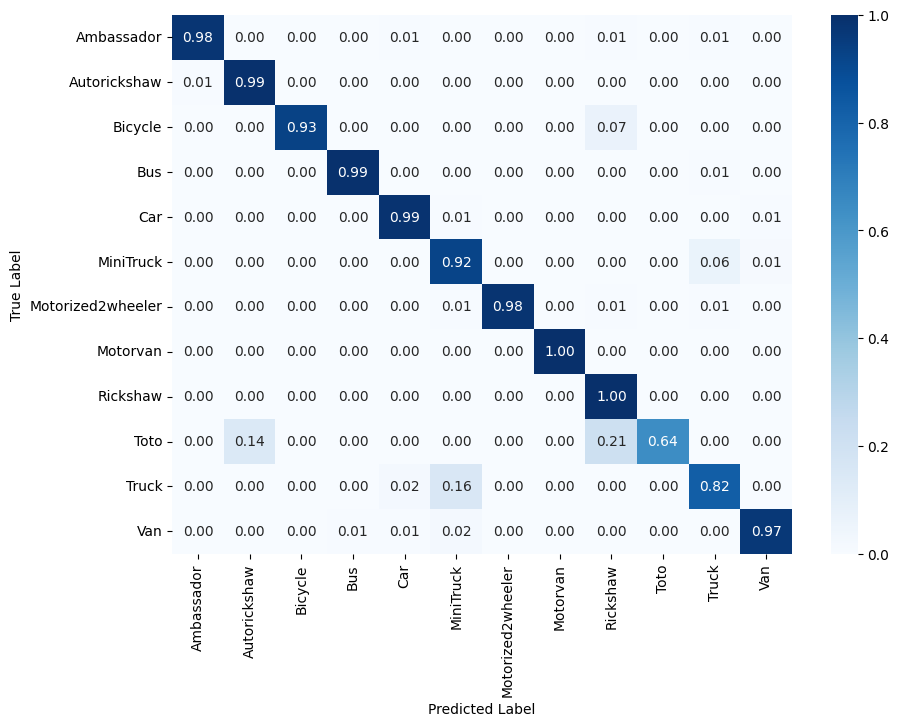

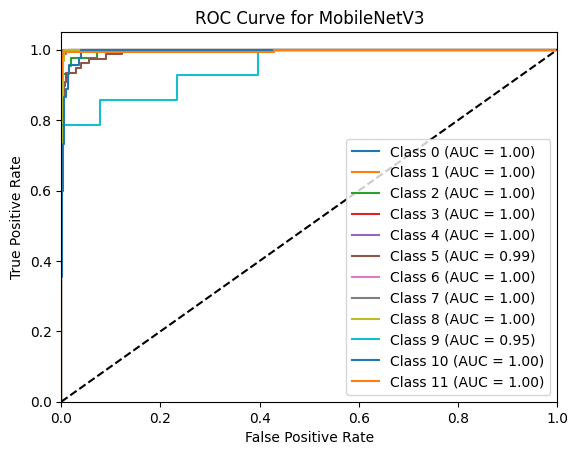

In [6]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

# Call the train_model function for MobileNetV3
train_model(
    base_model_class=MobileNetV3Large,             # MobileNetV3 Large model
    preprocess_input_function=preprocess_input,    # Preprocessing function for MobileNetV3
    model_name='MobileNetV3',                      # Name for the model
    class_names=class_names                        # Class names defined at the start
)


Found 3901 images belonging to 12 classes.
Found 1323 images belonging to 12 classes.
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


E0000 00:00:1748063985.917754     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748063986.106078     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748063986.513026     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748063986.697965     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748063987.125859     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

179/243 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.4789 - loss: 1.7525

E0000 00:00:1748064022.136172     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748064022.324530     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748064022.708346     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748064022.893120     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748064023.307817     111 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

243/243 ━━━━━━━━━━━━━━━━━━━━ 107s 224ms/step - accuracy: 0.5258 - loss: 1.5915 - val_accuracy: 0.8697 - val_loss: 0.4157
Epoch 2/50
  1/243 ━━━━━━━━━━━━━━━━━━━━ 16s 68ms/step - accuracy: 0.7500 - loss: 0.3232

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7500 - loss: 0.3232 - val_accuracy: 0.8666 - val_loss: 0.4196
Epoch 3/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 36s 147ms/step - accuracy: 0.8363 - loss: 0.5012 - val_accuracy: 0.9322 - val_loss: 0.2242
Epoch 4/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.8750 - loss: 0.4473 - val_accuracy: 0.9322 - val_loss: 0.2224
Epoch 5/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 35s 145ms/step - accuracy: 0.8938 - loss: 0.3340 - val_accuracy: 0.9383 - val_loss: 0.1771
Epoch 6/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9375 - loss: 0.2186 - val_accuracy: 0.9375 - val_loss: 0.1795
Epoch 7/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 35s 145ms/step - accuracy: 0.9334 - loss: 0.2191 - val_accuracy: 0.9558 - val_loss: 0.1619
Epoch 8/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.9375 - loss: 0.3680 - val_accuracy: 0.9543 - val_loss: 0.1619
Epoch 9/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 35s 143ms/step - accuracy: 0.9458 - loss: 0.1804 - val_accurac

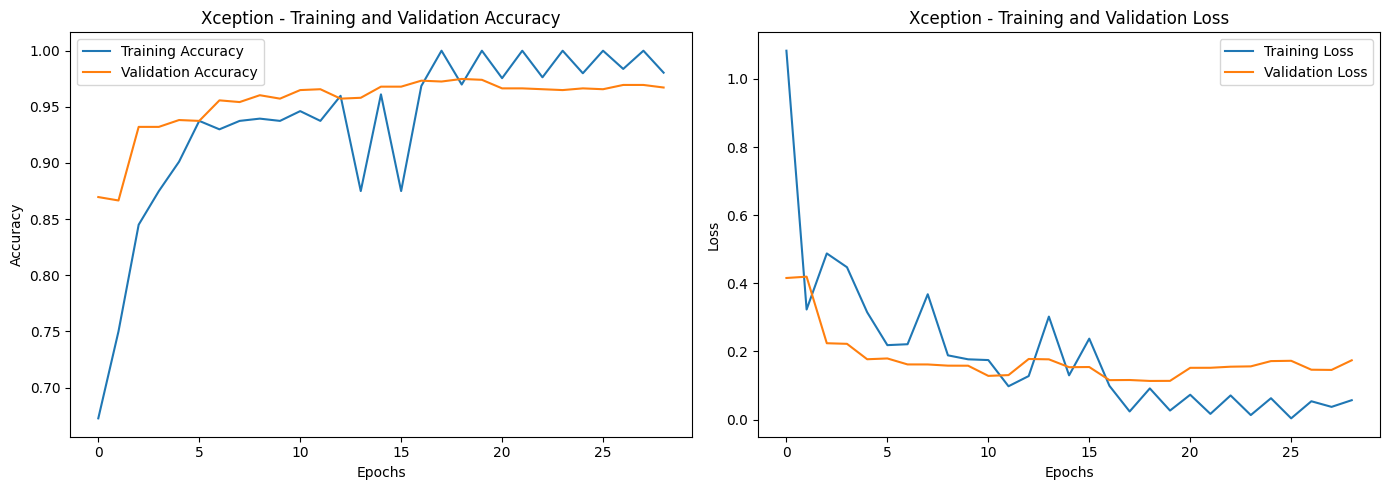

83/83 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step
Prediction time: 11.13393521308899 seconds

Model: Xception
Overall Accuracy: 0.98
Overall Precision: 0.98
Overall Recall: 0.98
Overall F1-Score: 0.97

Classification Report:
                   precision    recall  f1-score   support

       Ambassador       0.99      1.00      1.00       148
     Autorickshaw       1.00      0.99      0.99       182
          Bicycle       1.00      0.93      0.96        44
              Bus       1.00      0.99      1.00       190
              Car       0.99      0.99      0.99       149
        MiniTruck       0.91      0.90      0.90        77
Motorized2wheeler       0.99      0.99      0.99       160
         Motorvan       0.90      0.90      0.90        10
         Rickshaw       0.94      0.99      0.97       154
             Toto       1.00      0.79      0.88        14
            Truck       0.84      0.84      0.84        45
              Van       0.96      0.97      0.97       150

         accur

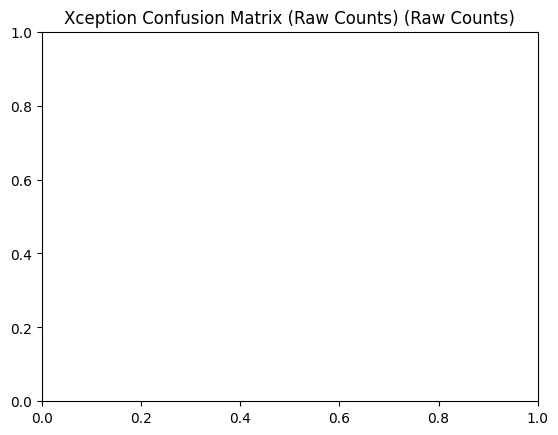

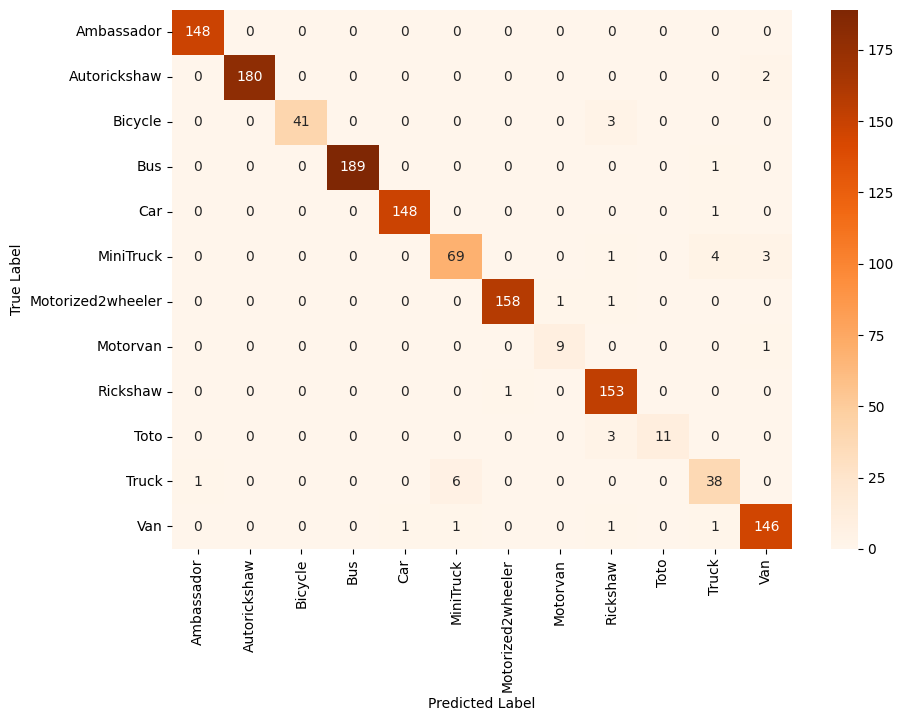

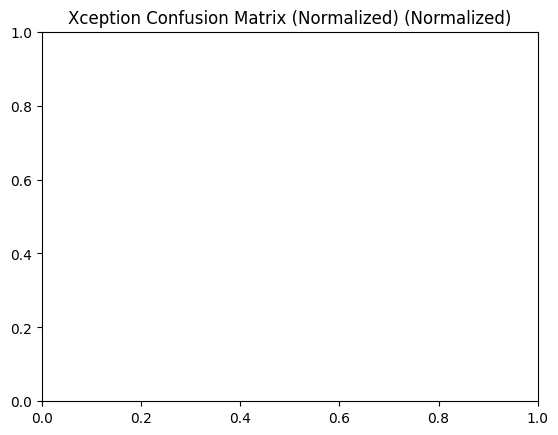

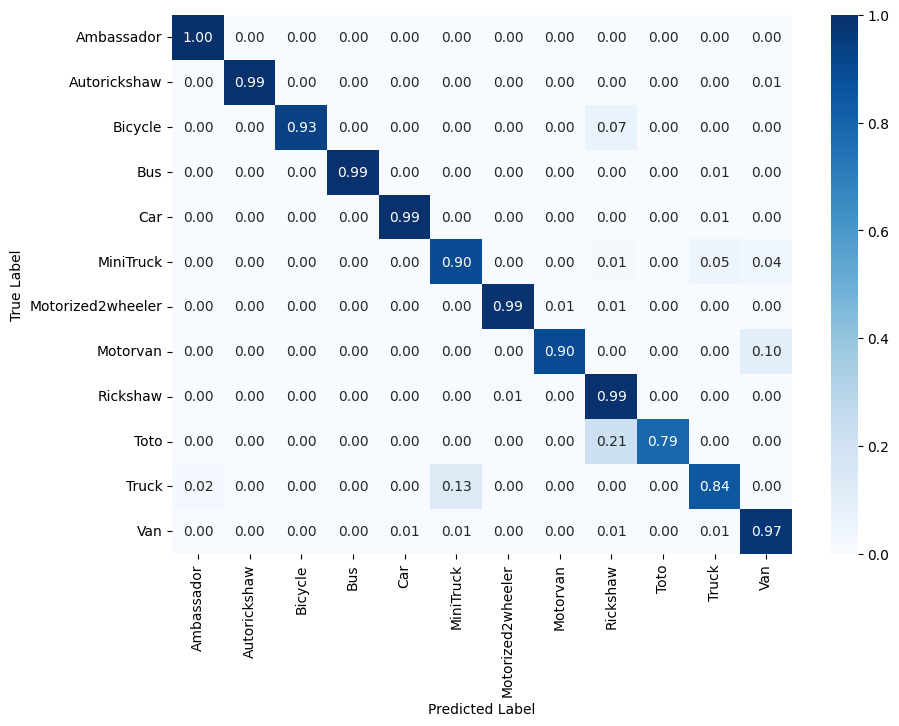

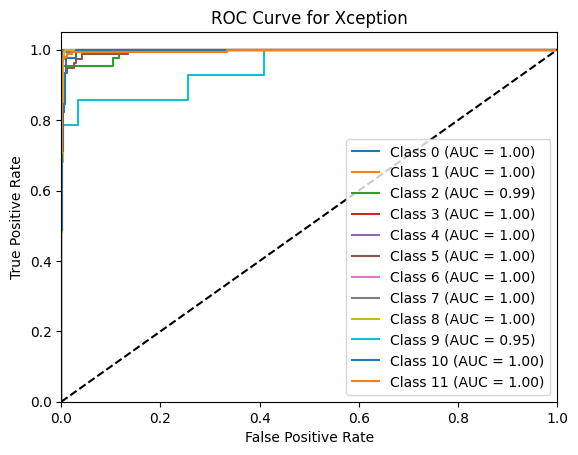

In [7]:
train_model(Xception, tf.keras.applications.xception.preprocess_input, 'Xception', class_names)

Found 3901 images belonging to 12 classes.
Found 1323 images belonging to 12 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 97s 204ms/step - accuracy: 0.5132 - loss: 1.6005 - val_accuracy: 0.8796 - val_loss: 0.4008
Epoch 2/50
  1/243 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - accuracy: 0.7500 - loss: 0.5955

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


243/243 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.7500 - loss: 0.5955 - val_accuracy: 0.8796 - val_loss: 0.3993
Epoch 3/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 36s 146ms/step - accuracy: 0.8253 - loss: 0.5947 - val_accuracy: 0.9261 - val_loss: 0.2634
Epoch 4/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 1.0000 - loss: 0.1701 - val_accuracy: 0.9253 - val_loss: 0.2654
Epoch 5/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 35s 145ms/step - accuracy: 0.8896 - loss: 0.3487 - val_accuracy: 0.9383 - val_loss: 0.2098
Epoch 6/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8125 - loss: 0.8103 - val_accuracy: 0.9367 - val_loss: 0.2103
Epoch 7/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 35s 142ms/step - accuracy: 0.9039 - loss: 0.3139 - val_accuracy: 0.9466 - val_loss: 0.1669
Epoch 8/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.8125 - loss: 0.6535 - val_accuracy: 0.9489 - val_loss: 0.1641
Epoch 9/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 35s 143ms/step - accuracy: 0.9382 - loss: 0.1945 - val_accurac

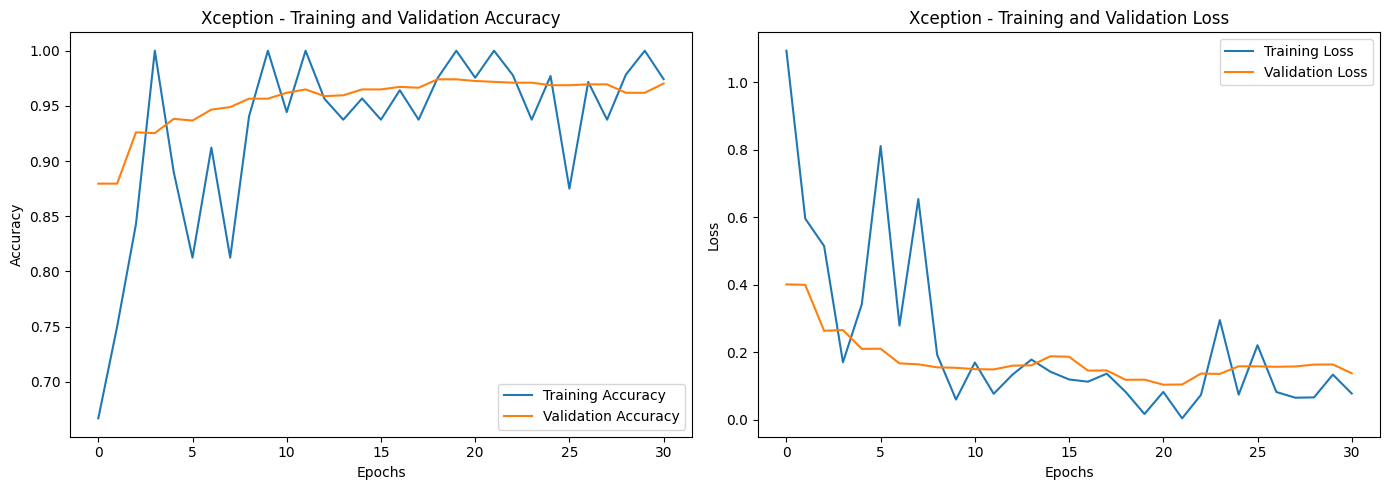

83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step
Prediction time: 9.636374950408936 seconds

Model: Xception
Overall Accuracy: 0.97
Overall Precision: 0.97
Overall Recall: 0.97
Overall F1-Score: 0.97

Classification Report:
                   precision    recall  f1-score   support

       Ambassador       1.00      1.00      1.00       148
     Autorickshaw       1.00      0.99      1.00       182
          Bicycle       1.00      0.95      0.98        44
              Bus       0.99      0.98      0.99       190
              Car       0.98      0.98      0.98       149
        MiniTruck       0.86      0.92      0.89        77
Motorized2wheeler       0.99      0.99      0.99       160
         Motorvan       1.00      1.00      1.00        10
         Rickshaw       0.96      0.99      0.98       154
             Toto       0.92      0.79      0.85        14
            Truck       0.85      0.76      0.80        45
              Van       0.96      0.97      0.97       150

         accurac

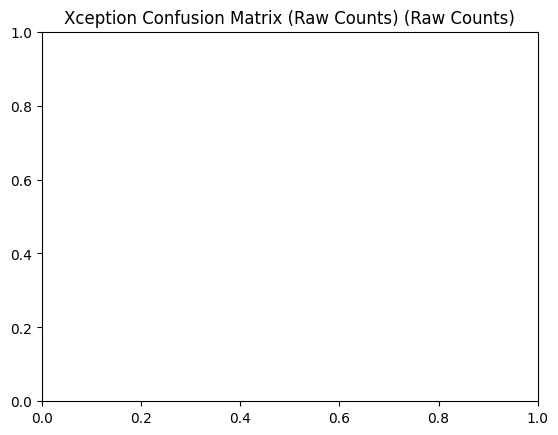

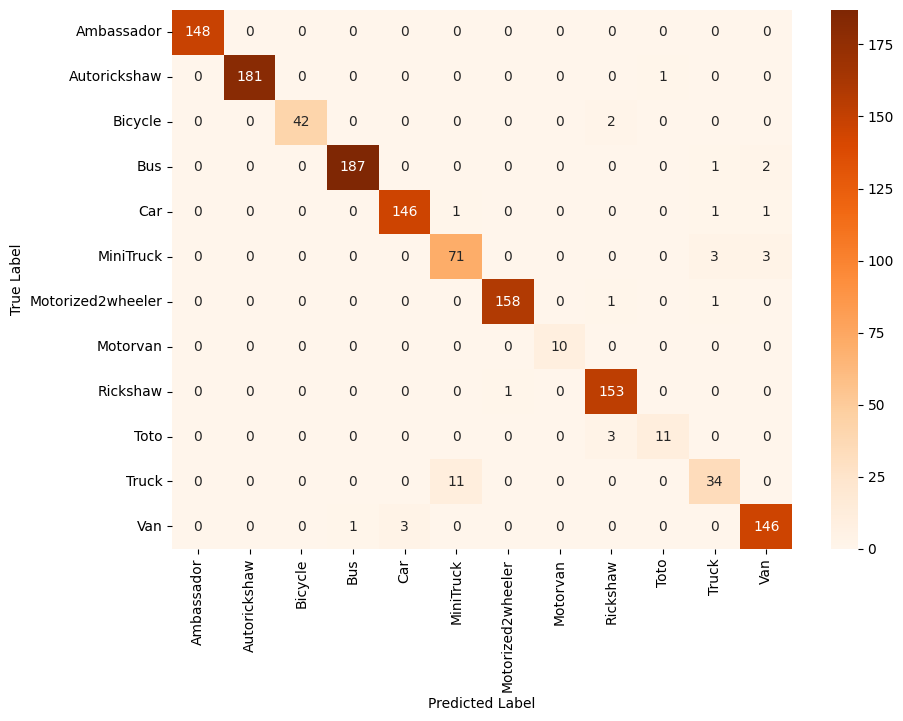

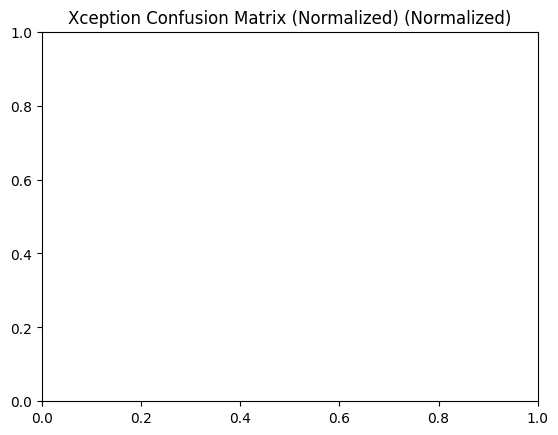

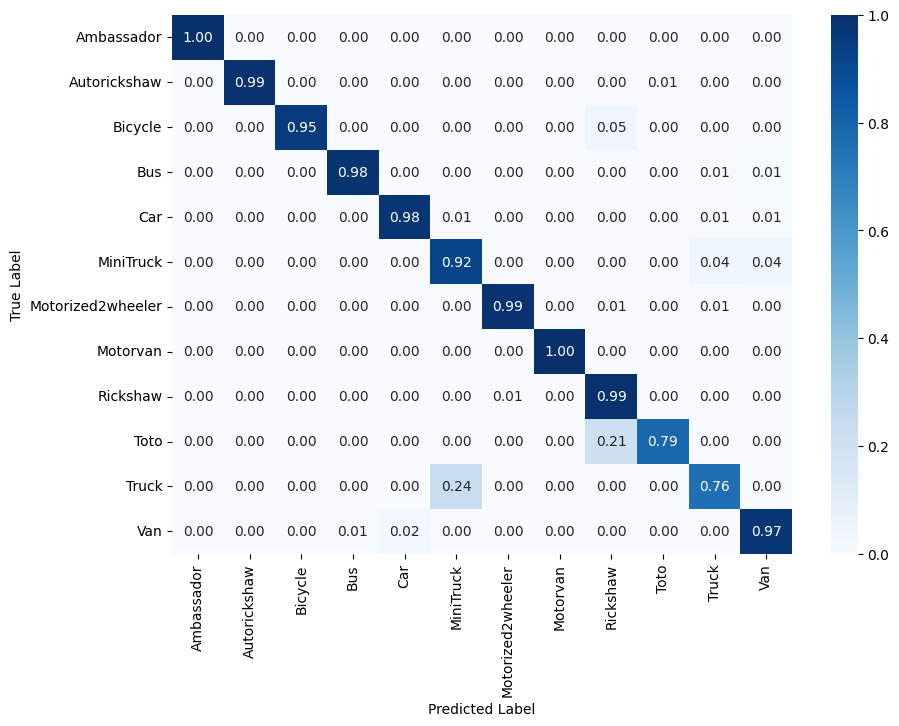

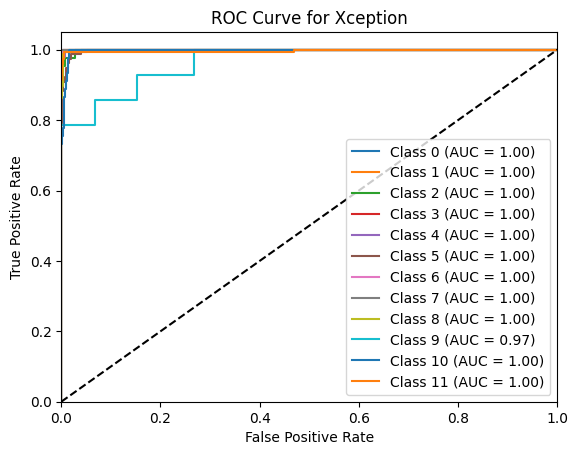

In [10]:
# Train each model separately
train_model(Xception, tf.keras.applications.xception.preprocess_input, 'Xception', class_names)

Found 3901 images belonging to 12 classes.
Found 1323 images belonging to 12 classes.
234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 297s 417ms/step - accuracy: 0.6447 - loss: 1.1765 - val_accuracy: 0.9085 - val_loss: 4.9138
Epoch 2/50
  1/243 ━━━━━━━━━━━━━━━━━━━━ 34s 144ms/step - accuracy: 0.9375 - loss: 0.1651

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


243/243 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9375 - loss: 0.1651 - val_accuracy: 0.9070 - val_loss: 5.1973
Epoch 3/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 45s 187ms/step - accuracy: 0.8884 - loss: 0.3398 - val_accuracy: 0.9245 - val_loss: 1.0235
Epoch 4/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.9375 - loss: 0.2705 - val_accuracy: 0.9245 - val_loss: 0.9898
Epoch 5/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 46s 188ms/step - accuracy: 0.9216 - loss: 0.2501 - val_accuracy: 0.9413 - val_loss: 0.8801
Epoch 6/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.7500 - loss: 0.7197 - val_accuracy: 0.9390 - val_loss: 1.2118
Epoch 7/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 46s 190ms/step - accuracy: 0.9415 - loss: 0.1846 - val_accuracy: 0.9276 - val_loss: 0.7317
Epoch 8/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9375 - loss: 0.2174 - val_accuracy: 0.9284 - val_loss: 0.7434
Epoch 9/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 46s 188ms/step - accuracy: 0.9421 - loss: 0.1879 - val_accura

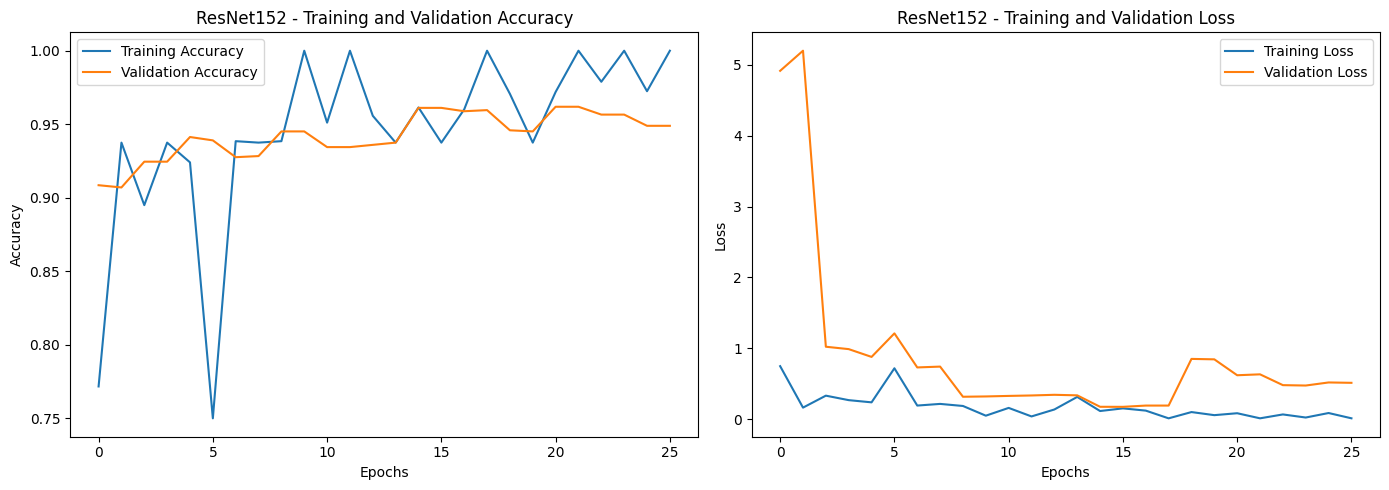

83/83 ━━━━━━━━━━━━━━━━━━━━ 29s 196ms/step
Prediction time: 29.340781688690186 seconds

Model: ResNet152
Overall Accuracy: 0.96
Overall Precision: 0.96
Overall Recall: 0.96
Overall F1-Score: 0.96

Classification Report:
                   precision    recall  f1-score   support

       Ambassador       0.99      1.00      0.99       148
     Autorickshaw       1.00      0.97      0.99       182
          Bicycle       0.98      0.91      0.94        44
              Bus       0.98      0.92      0.95       190
              Car       0.97      0.97      0.97       149
        MiniTruck       0.97      0.83      0.90        77
Motorized2wheeler       0.98      0.99      0.99       160
         Motorvan       1.00      0.80      0.89        10
         Rickshaw       0.94      1.00      0.97       154
             Toto       0.91      0.71      0.80        14
            Truck       0.75      1.00      0.86        45
              Van       0.92      0.97      0.95       150

         acc

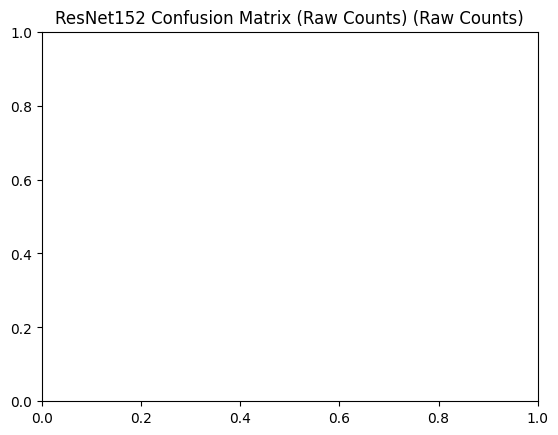

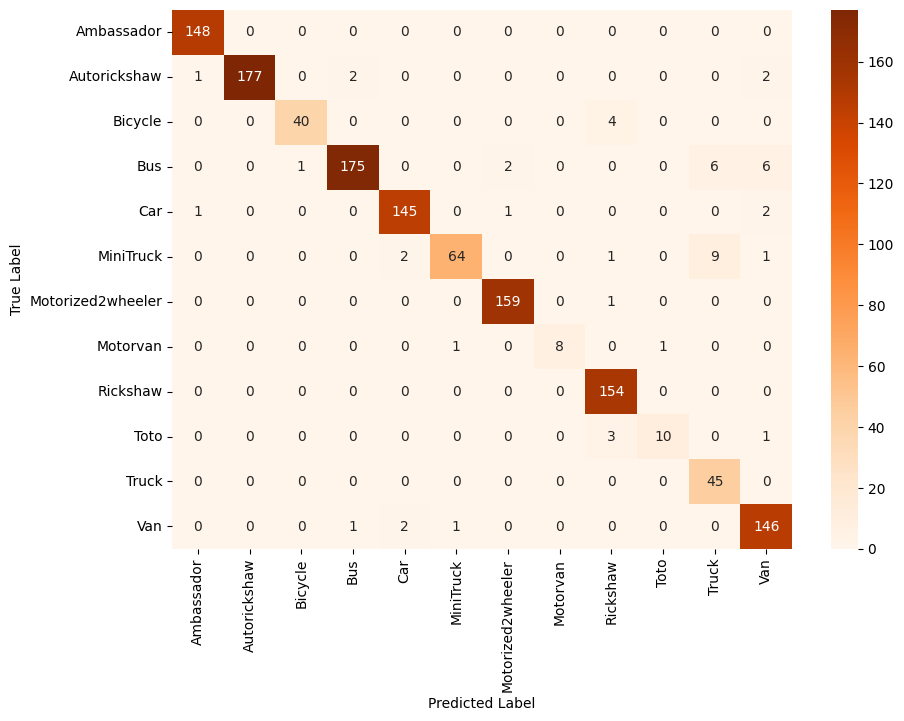

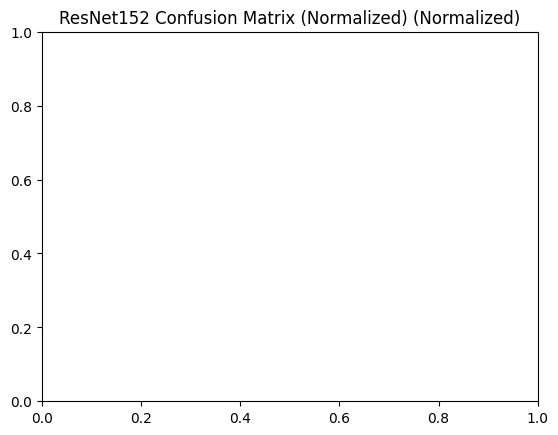

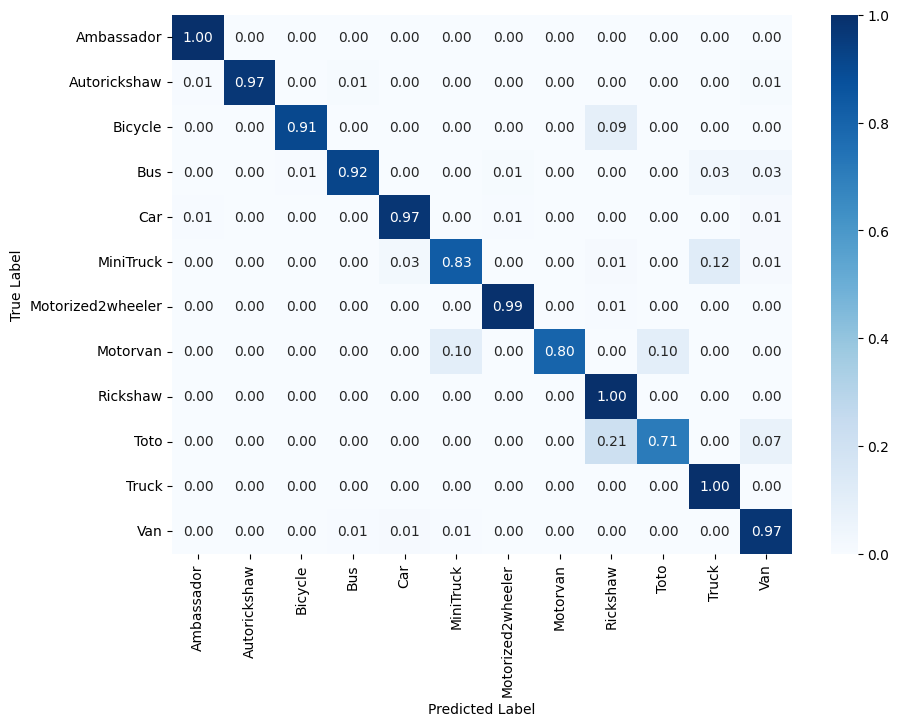

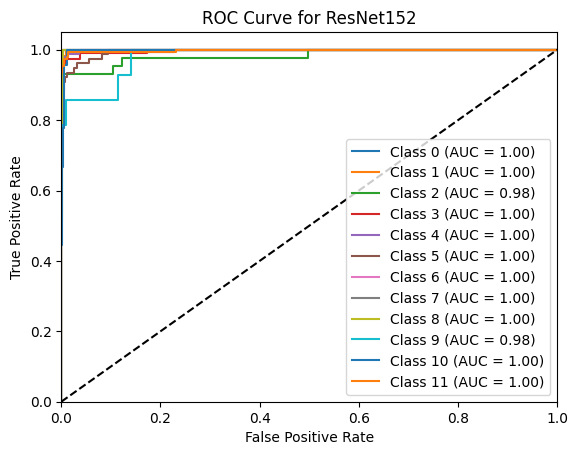

In [11]:
train_model(ResNet152, tf.keras.applications.resnet.preprocess_input, 'ResNet152', class_names)

Found 3901 images belonging to 12 classes.
Found 1323 images belonging to 12 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


E0000 00:00:1748066596.189315     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748066596.385242     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


205/243 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.5851 - loss: 1.3725

E0000 00:00:1748066635.500228     110 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748066635.696078     110 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


243/243 ━━━━━━━━━━━━━━━━━━━━ 112s 220ms/step - accuracy: 0.6084 - loss: 1.2951 - val_accuracy: 0.8293 - val_loss: 0.5552
Epoch 2/50
  1/243 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.8750 - loss: 0.4136

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


243/243 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.8750 - loss: 0.4136 - val_accuracy: 0.8316 - val_loss: 0.5487
Epoch 3/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 33s 136ms/step - accuracy: 0.8416 - loss: 0.4916 - val_accuracy: 0.9108 - val_loss: 0.2732
Epoch 4/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8750 - loss: 0.5483 - val_accuracy: 0.9108 - val_loss: 0.2744
Epoch 5/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - accuracy: 0.8724 - loss: 0.3449 - val_accuracy: 0.9436 - val_loss: 0.2022
Epoch 6/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 1.0000 - loss: 0.1215 - val_accuracy: 0.9421 - val_loss: 0.2024
Epoch 7/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 32s 133ms/step - accuracy: 0.9025 - loss: 0.2896 - val_accuracy: 0.9436 - val_loss: 0.1924
Epoch 8/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9375 - loss: 0.3903 - val_accuracy: 0.9436 - val_loss: 0.1905
Epoch 9/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 35s 143ms/step - accuracy: 0.9223 - loss: 0.2336 - val_accurac

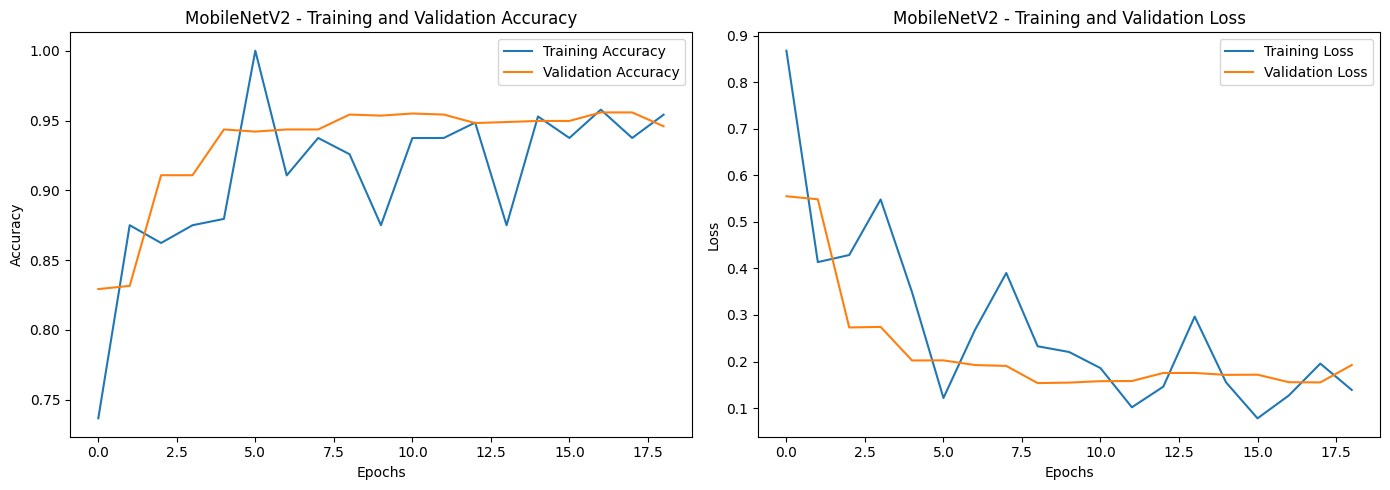

83/83 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step
Prediction time: 11.230355739593506 seconds

Model: MobileNetV2
Overall Accuracy: 0.95
Overall Precision: 0.96
Overall Recall: 0.95
Overall F1-Score: 0.95

Classification Report:
                   precision    recall  f1-score   support

       Ambassador       1.00      0.99      0.99       148
     Autorickshaw       0.98      0.98      0.98       182
          Bicycle       1.00      0.91      0.95        44
              Bus       0.96      0.95      0.95       190
              Car       0.96      0.97      0.96       149
        MiniTruck       0.95      0.79      0.87        77
Motorized2wheeler       1.00      1.00      1.00       160
         Motorvan       1.00      0.90      0.95        10
         Rickshaw       0.93      1.00      0.96       154
             Toto       1.00      0.29      0.44        14
            Truck       0.79      0.84      0.82        45
              Van       0.90      0.99      0.94       150

         ac

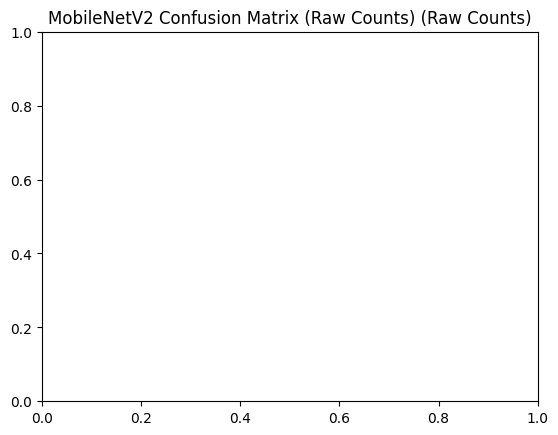

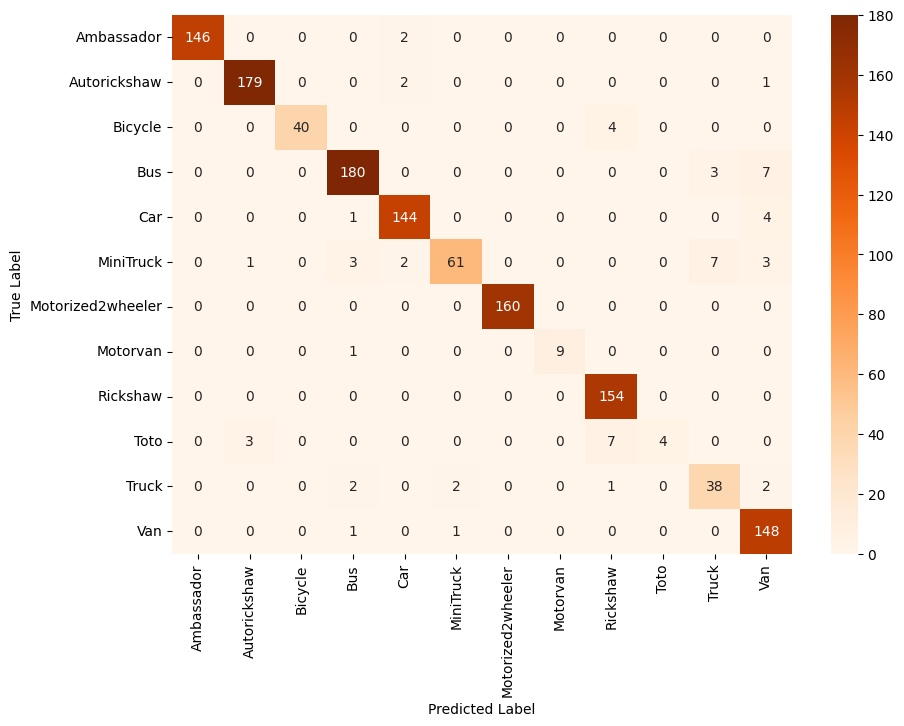

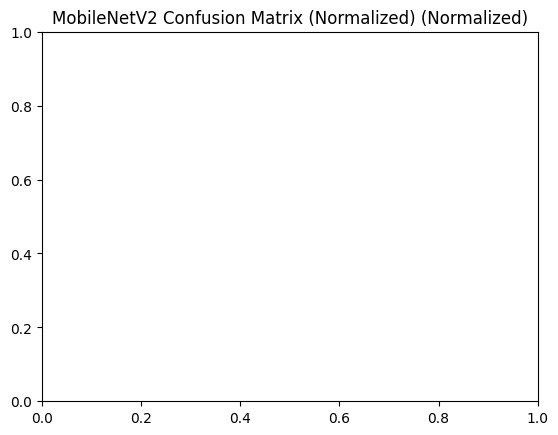

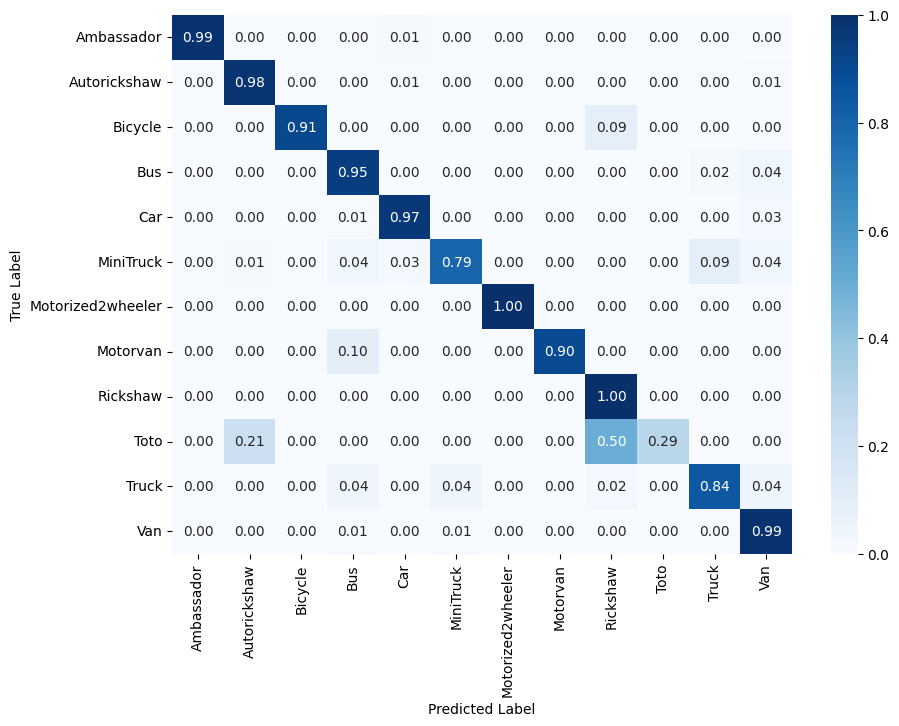

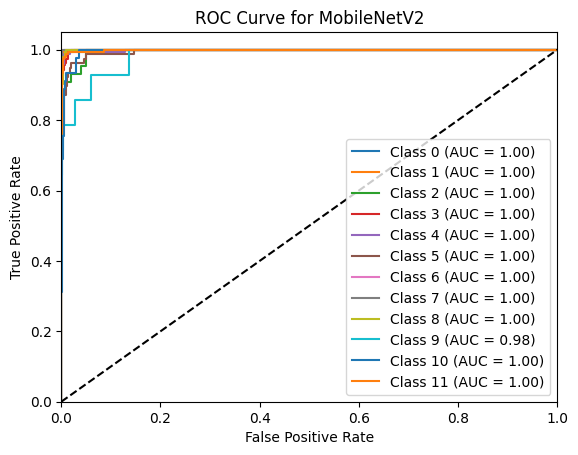

In [12]:
train_model(MobileNetV2, tf.keras.applications.mobilenet_v2.preprocess_input, 'MobileNetV2',class_names)

Found 3901 images belonging to 12 classes.
Found 1323 images belonging to 12 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 102s 199ms/step - accuracy: 0.6092 - loss: 1.2857 - val_accuracy: 0.8765 - val_loss: 0.3902
Epoch 2/50
  1/243 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.7500 - loss: 0.6971

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


243/243 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7500 - loss: 0.6971 - val_accuracy: 0.8750 - val_loss: 0.3857
Epoch 3/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 32s 132ms/step - accuracy: 0.8504 - loss: 0.4485 - val_accuracy: 0.9139 - val_loss: 0.2850
Epoch 4/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9375 - loss: 0.4155 - val_accuracy: 0.9146 - val_loss: 0.2863
Epoch 5/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 33s 135ms/step - accuracy: 0.8891 - loss: 0.3505 - val_accuracy: 0.9497 - val_loss: 0.1888
Epoch 6/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8125 - loss: 0.6749 - val_accuracy: 0.9466 - val_loss: 0.1899
Epoch 7/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 31s 127ms/step - accuracy: 0.9118 - loss: 0.2860 - val_accuracy: 0.9306 - val_loss: 0.2594
Epoch 8/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7500 - loss: 0.5136 - val_accuracy: 0.9284 - val_loss: 0.2617
Epoch 9/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - accuracy: 0.9322 - loss: 0.2140 - val_accurac

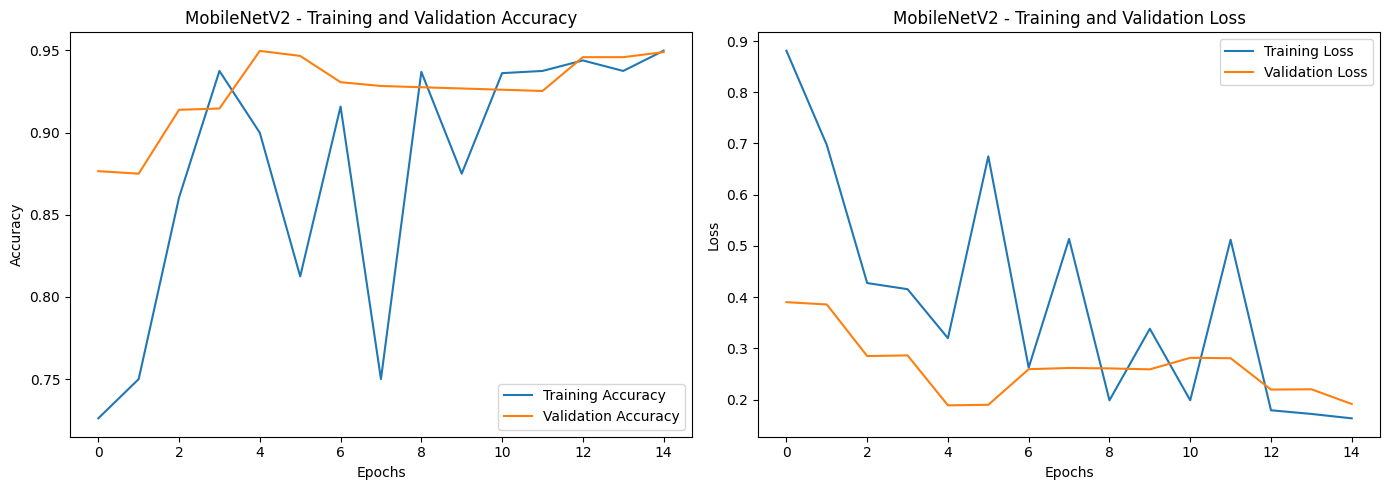

83/83 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step
Prediction time: 12.2960045337677 seconds

Model: MobileNetV2
Overall Accuracy: 0.95
Overall Precision: 0.95
Overall Recall: 0.95
Overall F1-Score: 0.95

Classification Report:
                   precision    recall  f1-score   support

       Ambassador       0.94      0.99      0.97       148
     Autorickshaw       1.00      0.97      0.98       182
          Bicycle       0.97      0.86      0.92        44
              Bus       0.98      0.95      0.97       190
              Car       0.95      0.94      0.95       149
        MiniTruck       0.92      0.86      0.89        77
Motorized2wheeler       0.96      0.98      0.97       160
         Motorvan       1.00      0.80      0.89        10
         Rickshaw       0.93      0.99      0.96       154
             Toto       1.00      0.43      0.60        14
            Truck       0.79      0.84      0.82        45
              Van       0.92      0.99      0.95       150

         acc

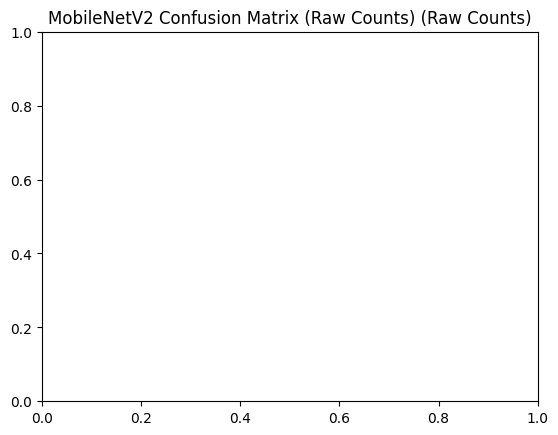

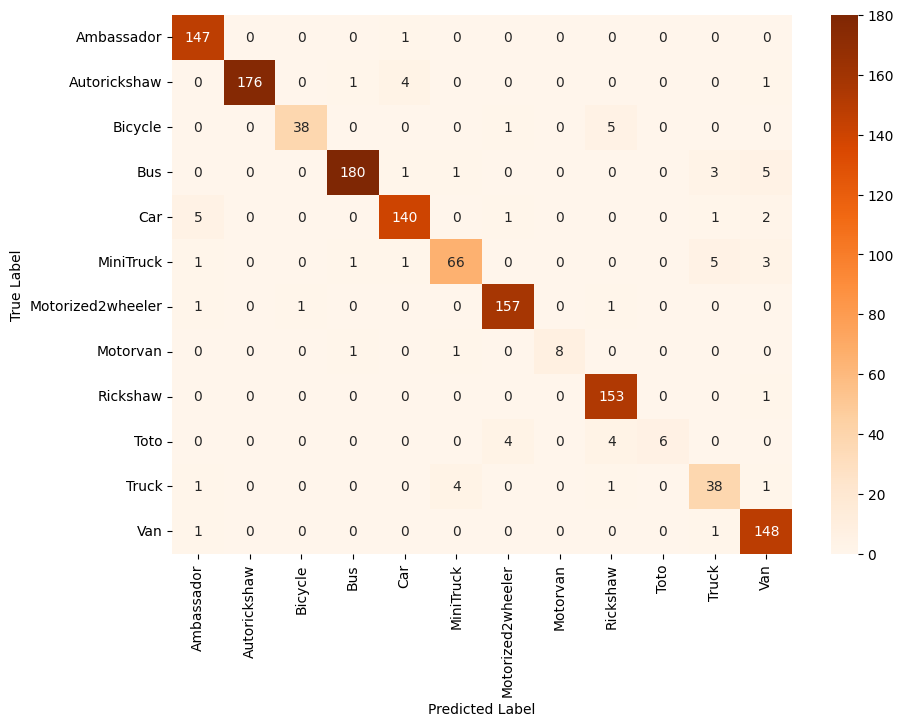

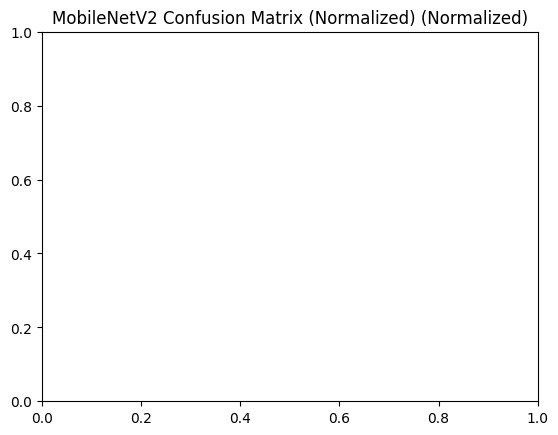

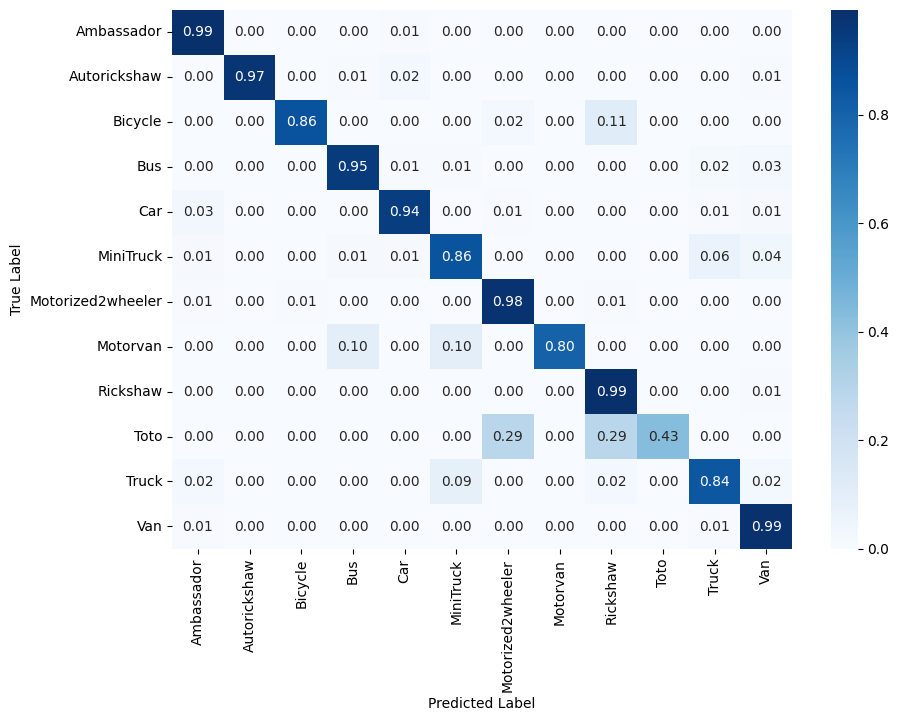

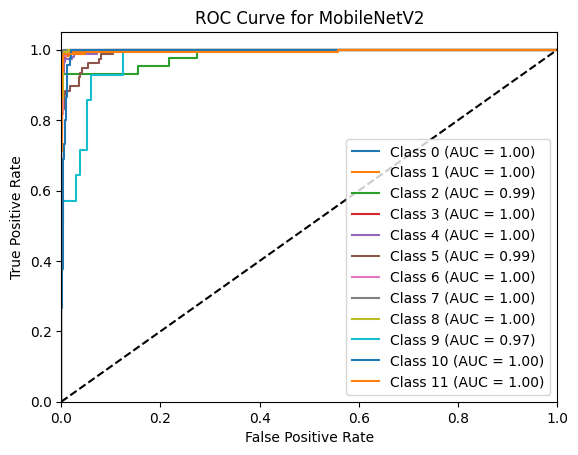

In [13]:
train_model(MobileNetV2, tf.keras.applications.mobilenet_v2.preprocess_input, 'MobileNetV2', class_names)

Found 3901 images belonging to 12 classes.
Found 1323 images belonging to 12 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 320s 544ms/step - accuracy: 0.5872 - loss: 1.3838 - val_accuracy: 0.9123 - val_loss: 0.2767
Epoch 2/50
  1/243 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - accuracy: 0.6875 - loss: 1.1861

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


243/243 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.6875 - loss: 1.1861 - val_accuracy: 0.9139 - val_loss: 0.2713
Epoch 3/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 42s 172ms/step - accuracy: 0.8803 - loss: 0.3874 - val_accuracy: 0.9505 - val_loss: 0.1749
Epoch 4/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.8750 - loss: 0.3282 - val_accuracy: 0.9497 - val_loss: 0.1767
Epoch 5/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 45s 185ms/step - accuracy: 0.9270 - loss: 0.2160 - val_accuracy: 0.9573 - val_loss: 0.1560
Epoch 6/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.9375 - loss: 0.2732 - val_accuracy: 0.9588 - val_loss: 0.1558
Epoch 7/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 41s 170ms/step - accuracy: 0.9370 - loss: 0.2062 - val_accuracy: 0.9665 - val_loss: 0.1332
Epoch 8/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.8750 - loss: 0.3348 - val_accuracy: 0.9649 - val_loss: 0.1347
Epoch 9/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 42s 171ms/step - accuracy: 0.9549 - loss: 0.1500 - val_accurac

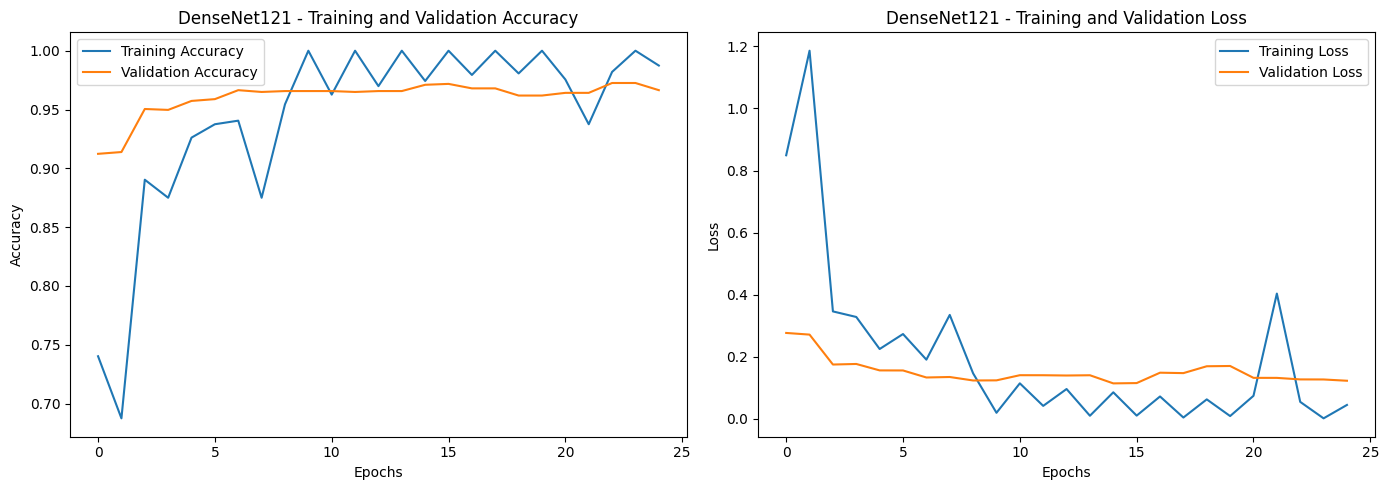

83/83 ━━━━━━━━━━━━━━━━━━━━ 32s 238ms/step
Prediction time: 31.86167883872986 seconds

Model: DenseNet121
Overall Accuracy: 0.97
Overall Precision: 0.97
Overall Recall: 0.97
Overall F1-Score: 0.97

Classification Report:
                   precision    recall  f1-score   support

       Ambassador       1.00      1.00      1.00       148
     Autorickshaw       1.00      0.98      0.99       182
          Bicycle       0.91      0.93      0.92        44
              Bus       0.97      0.99      0.98       190
              Car       0.97      0.97      0.97       149
        MiniTruck       0.99      0.87      0.92        77
Motorized2wheeler       0.99      0.97      0.98       160
         Motorvan       1.00      0.90      0.95        10
         Rickshaw       0.96      0.99      0.97       154
             Toto       0.91      0.71      0.80        14
            Truck       0.86      0.96      0.91        45
              Van       0.95      0.97      0.96       150

         ac

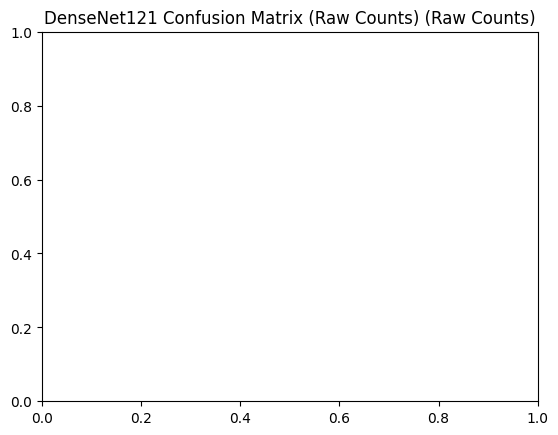

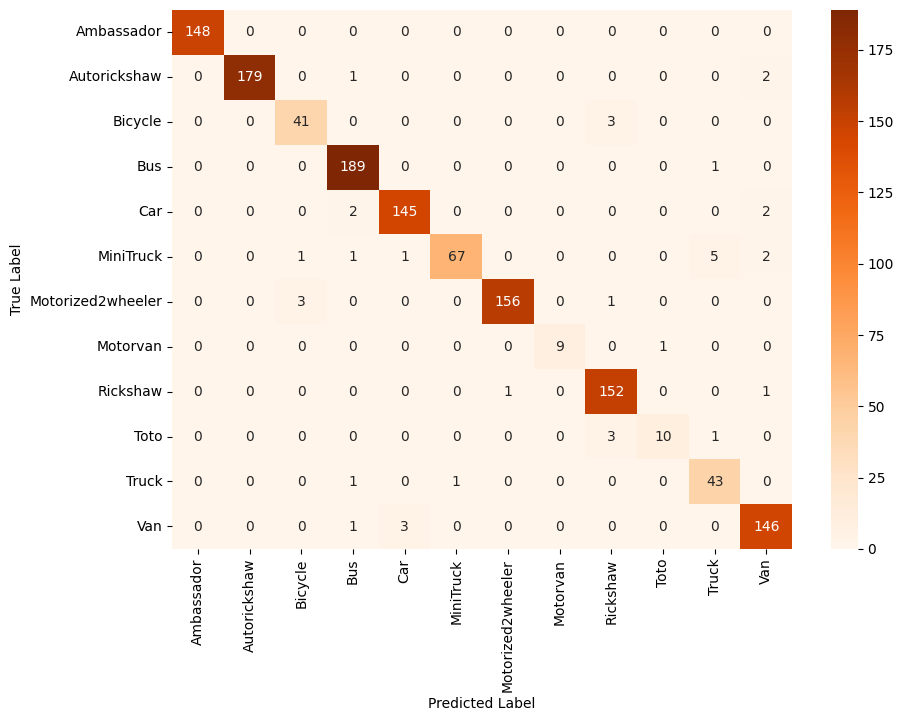

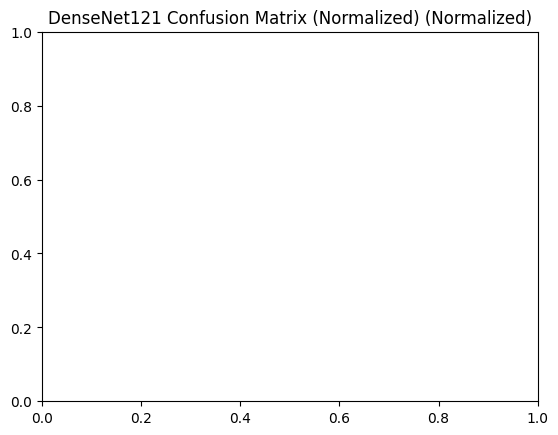

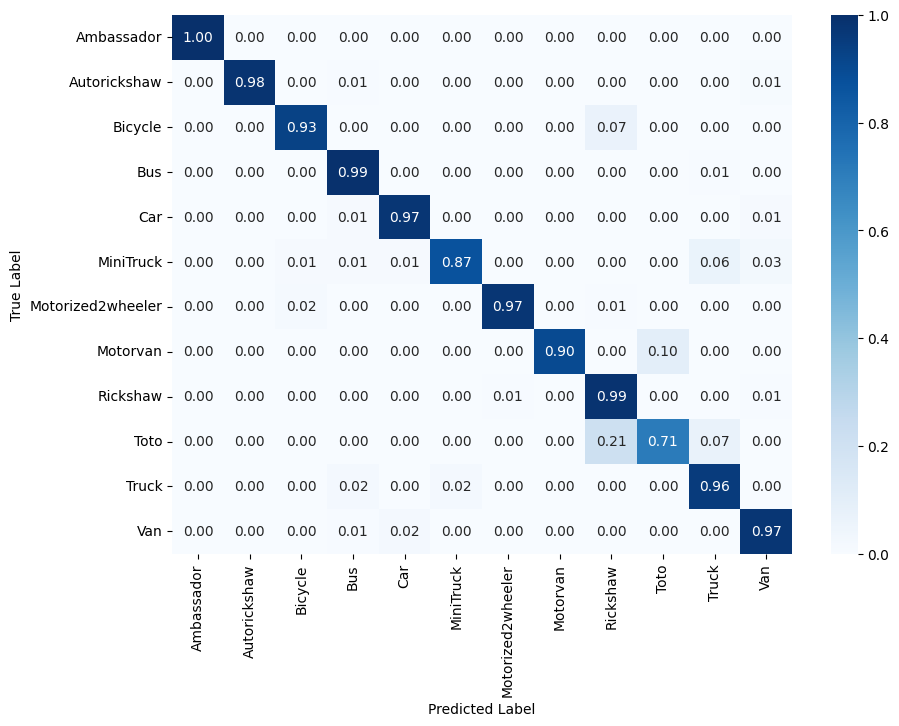

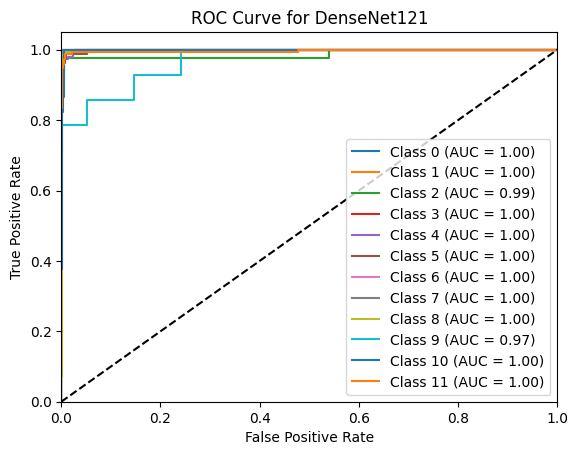

In [14]:
train_model(DenseNet121, tf.keras.applications.densenet.preprocess_input, 'DenseNet121',class_names)

Found 3901 images belonging to 12 classes.
Found 1323 images belonging to 12 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 183s 351ms/step - accuracy: 0.3312 - loss: 2.2174 - val_accuracy: 0.7759 - val_loss: 0.8244
Epoch 2/50
  1/243 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - accuracy: 0.7500 - loss: 1.0637

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


243/243 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.7500 - loss: 1.0637 - val_accuracy: 0.7767 - val_loss: 0.8212
Epoch 3/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 166ms/step - accuracy: 0.6684 - loss: 1.0718 - val_accuracy: 0.8537 - val_loss: 0.5062
Epoch 4/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.7500 - loss: 0.9108 - val_accuracy: 0.8514 - val_loss: 0.5038
Epoch 5/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 164ms/step - accuracy: 0.7458 - loss: 0.8186 - val_accuracy: 0.8727 - val_loss: 0.3970
Epoch 6/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.8125 - loss: 0.3797 - val_accuracy: 0.8727 - val_loss: 0.3969
Epoch 7/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 165ms/step - accuracy: 0.8152 - loss: 0.5983 - val_accuracy: 0.8994 - val_loss: 0.3213
Epoch 8/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - accuracy: 0.8125 - loss: 0.4761 - val_accuracy: 0.8986 - val_loss: 0.3212
Epoch 9/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 164ms/step - accuracy: 0.8380 - loss: 0.5113 - val_accura

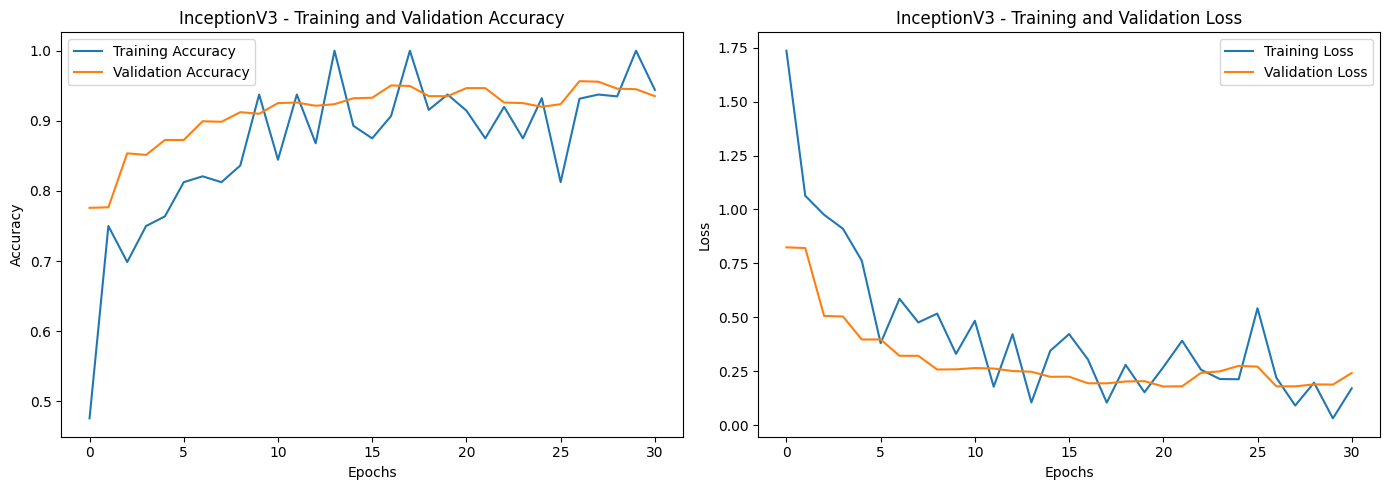

83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step
Prediction time: 17.93341875076294 seconds

Model: InceptionV3
Overall Accuracy: 0.95
Overall Precision: 0.95
Overall Recall: 0.95
Overall F1-Score: 0.94

Classification Report:
                   precision    recall  f1-score   support

       Ambassador       0.99      0.99      0.99       148
     Autorickshaw       1.00      0.99      0.99       182
          Bicycle       0.90      0.86      0.88        44
              Bus       0.95      0.98      0.97       190
              Car       0.97      0.93      0.95       149
        MiniTruck       0.90      0.82      0.86        77
Motorized2wheeler       0.97      0.96      0.97       160
         Motorvan       1.00      0.70      0.82        10
         Rickshaw       0.90      0.99      0.94       154
             Toto       1.00      0.29      0.44        14
            Truck       0.82      0.91      0.86        45
              Van       0.92      0.95      0.93       150

         ac

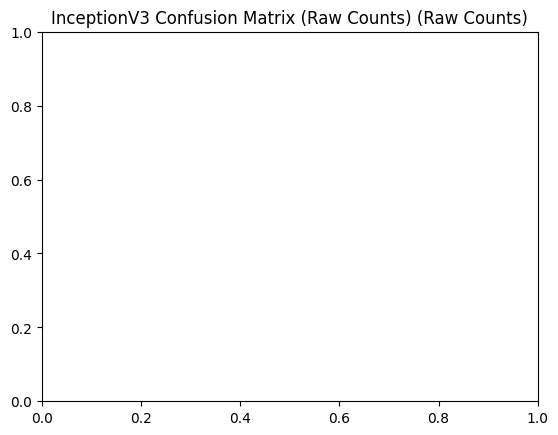

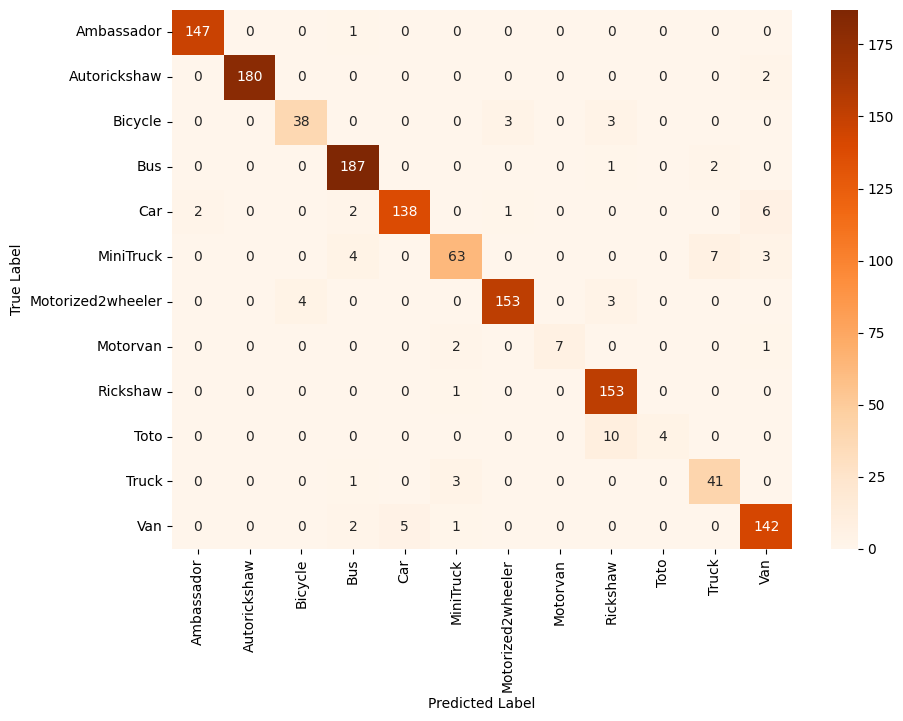

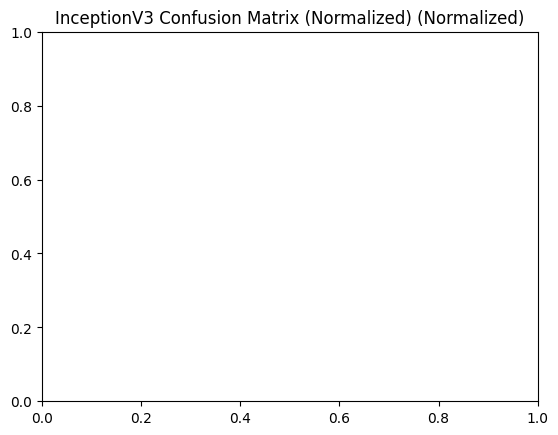

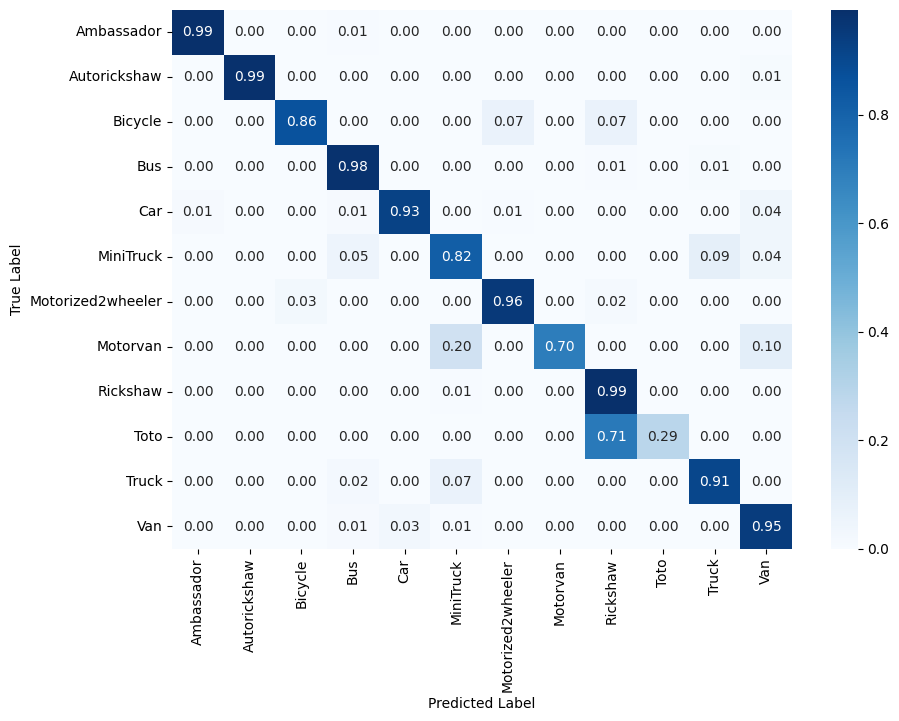

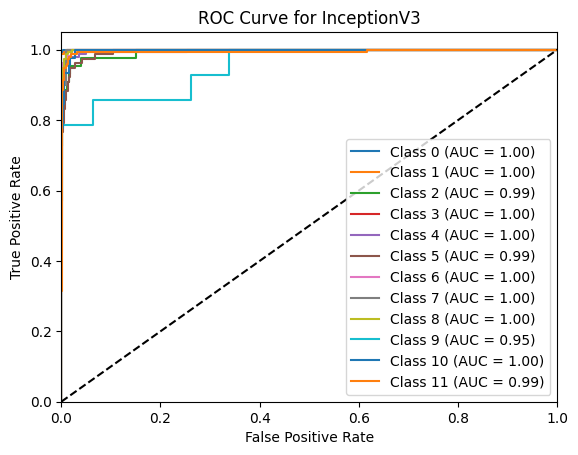

In [15]:
train_model(InceptionV3, tf.keras.applications.inception_v3.preprocess_input, 'InceptionV3',class_names)

Found 3901 images belonging to 12 classes.
Found 1323 images belonging to 12 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


E0000 00:00:1748069418.782022     109 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748069418.964040     109 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748069419.275800     109 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748069419.464781     109 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748069419.751880     109 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

113/243 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step - accuracy: 0.4080 - loss: 2.0314

E0000 00:00:1748069462.198656     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748069462.380697     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748069462.693335     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748069462.882224     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748069463.167953     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

243/243 ━━━━━━━━━━━━━━━━━━━━ 157s 288ms/step - accuracy: 0.5363 - loss: 1.5741 - val_accuracy: 0.9139 - val_loss: 0.2838
Epoch 2/50
  1/243 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.8750 - loss: 0.7051

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


243/243 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.8750 - loss: 0.7051 - val_accuracy: 0.9139 - val_loss: 0.2823
Epoch 3/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 32s 133ms/step - accuracy: 0.8375 - loss: 0.4944 - val_accuracy: 0.9322 - val_loss: 0.2431
Epoch 4/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7500 - loss: 1.2064 - val_accuracy: 0.9337 - val_loss: 0.2439
Epoch 5/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 33s 135ms/step - accuracy: 0.8940 - loss: 0.3228 - val_accuracy: 0.9436 - val_loss: 0.1893
Epoch 6/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9375 - loss: 0.3419 - val_accuracy: 0.9451 - val_loss: 0.1887
Epoch 7/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - accuracy: 0.9142 - loss: 0.2670 - val_accuracy: 0.9604 - val_loss: 0.1708
Epoch 8/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8125 - loss: 0.5457 - val_accuracy: 0.9604 - val_loss: 0.1712
Epoch 9/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 30s 123ms/step - accuracy: 0.9310 - loss: 0.2137 - val_accurac

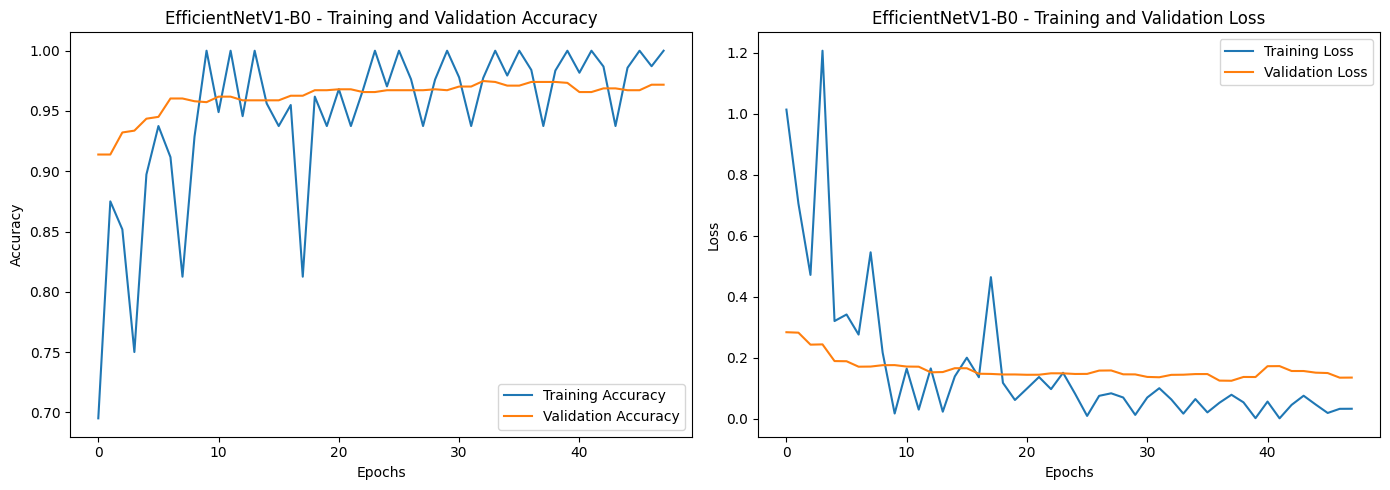

83/83 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step
Prediction time: 17.222070693969727 seconds

Model: EfficientNetV1-B0
Overall Accuracy: 0.97
Overall Precision: 0.98
Overall Recall: 0.97
Overall F1-Score: 0.97

Classification Report:
                   precision    recall  f1-score   support

       Ambassador       0.99      1.00      0.99       148
     Autorickshaw       1.00      0.99      0.99       182
          Bicycle       0.97      0.89      0.93        44
              Bus       0.98      0.99      0.99       190
              Car       1.00      0.97      0.99       149
        MiniTruck       0.97      0.90      0.93        77
Motorized2wheeler       0.99      0.99      0.99       160
         Motorvan       0.83      1.00      0.91        10
         Rickshaw       0.94      0.98      0.96       154
             Toto       1.00      0.57      0.73        14
            Truck       0.90      0.96      0.92        45
              Van       0.95      0.99      0.97       150

    

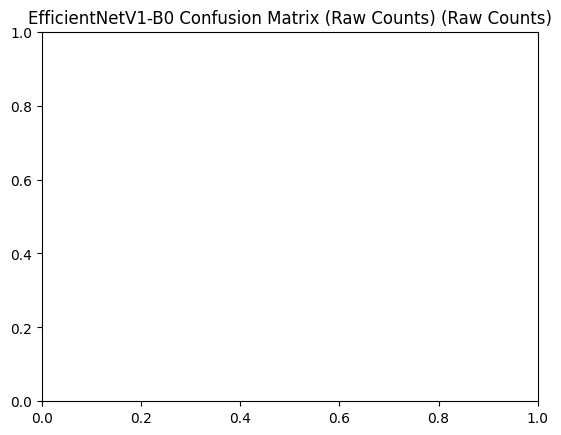

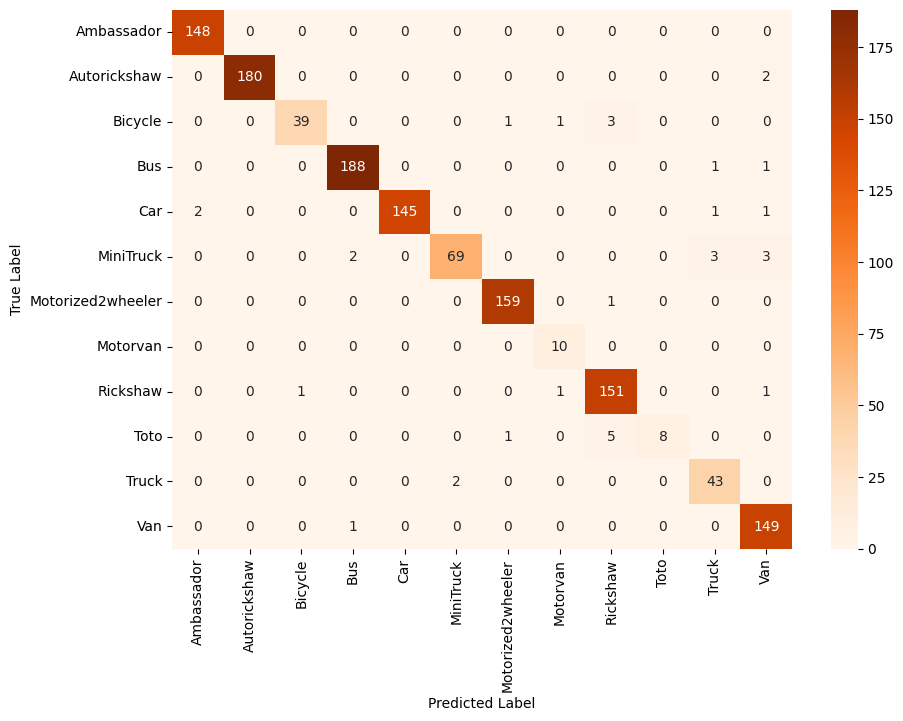

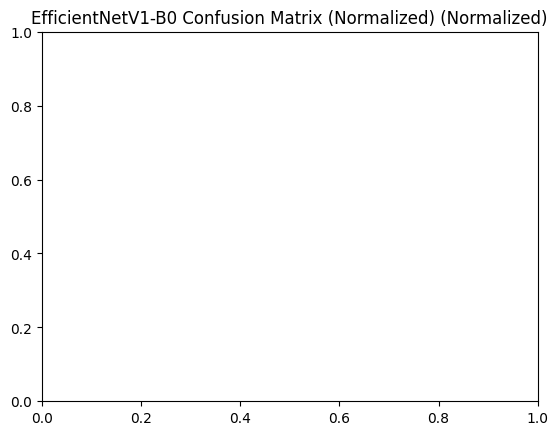

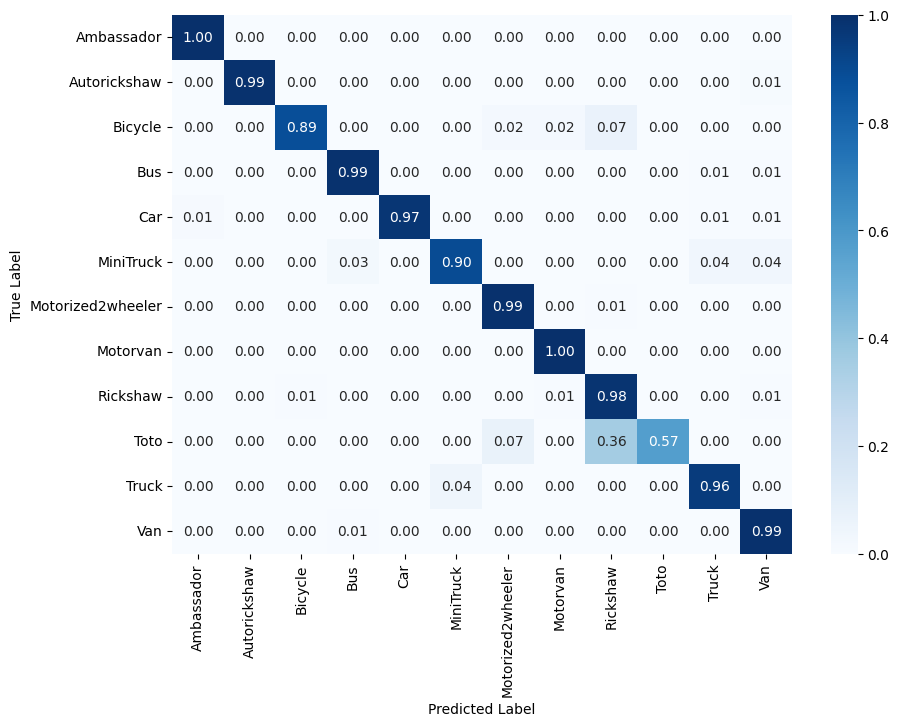

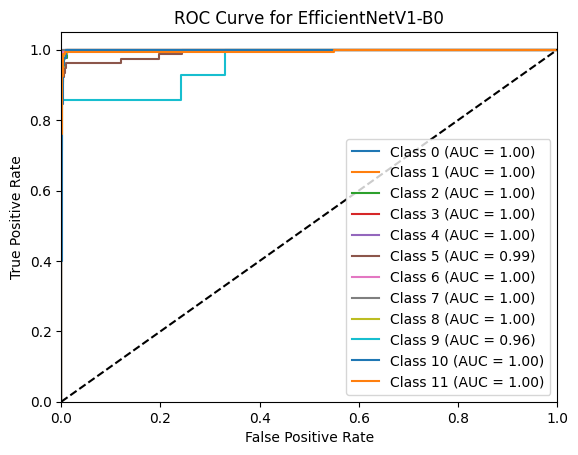

In [16]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

train_model(EfficientNetB0, preprocess_input, 'EfficientNetV1-B0', class_names)

Found 3901 images belonging to 12 classes.
Found 1323 images belonging to 12 classes.
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 165s 276ms/step - accuracy: 0.5248 - loss: 1.5634 - val_accuracy: 0.8994 - val_loss: 0.3093
Epoch 2/50
  1/243 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.8750 - loss: 0.3561

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.8750 - loss: 0.3561 - val_accuracy: 0.9032 - val_loss: 0.3103
Epoch 3/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 32s 133ms/step - accuracy: 0.8607 - loss: 0.4479 - val_accuracy: 0.9451 - val_loss: 0.1841
Epoch 4/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8125 - loss: 0.5063 - val_accuracy: 0.9428 - val_loss: 0.1844
Epoch 5/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 33s 134ms/step - accuracy: 0.8997 - loss: 0.3139 - val_accuracy: 0.9588 - val_loss: 0.1405
Epoch 6/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8750 - loss: 0.1682 - val_accuracy: 0.9611 - val_loss: 0.1378
Epoch 7/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 32s 133ms/step - accuracy: 0.9275 - loss: 0.2259 - val_accuracy: 0.9604 - val_loss: 0.1249
Epoch 8/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 1.0000 - loss: 0.1177 - val_accuracy: 0.9634 - val_loss: 0.1221
Epoch 9/50
243/243 ━━━━━━━━━━━━━━━━━━━━ 32s 132ms/step - accuracy: 0.9408 - loss: 0.1950 - val_accurac

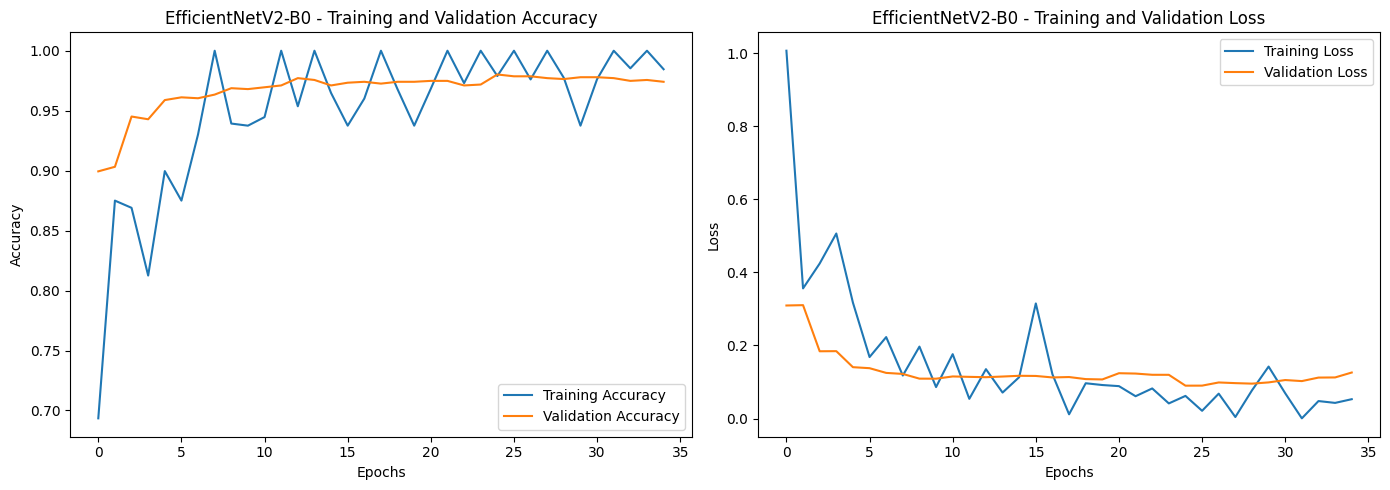

83/83 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step
Prediction time: 16.82209610939026 seconds

Model: EfficientNetV2-B0
Overall Accuracy: 0.98
Overall Precision: 0.98
Overall Recall: 0.98
Overall F1-Score: 0.98

Classification Report:
                   precision    recall  f1-score   support

       Ambassador       0.98      1.00      0.99       148
     Autorickshaw       0.99      0.99      0.99       182
          Bicycle       1.00      0.93      0.96        44
              Bus       1.00      0.99      0.99       190
              Car       0.99      0.97      0.98       149
        MiniTruck       0.97      0.92      0.95        77
Motorized2wheeler       1.00      1.00      1.00       160
         Motorvan       1.00      1.00      1.00        10
         Rickshaw       0.96      1.00      0.98       154
             Toto       1.00      0.71      0.83        14
            Truck       0.86      0.96      0.91        45
              Van       0.97      0.99      0.98       150

     

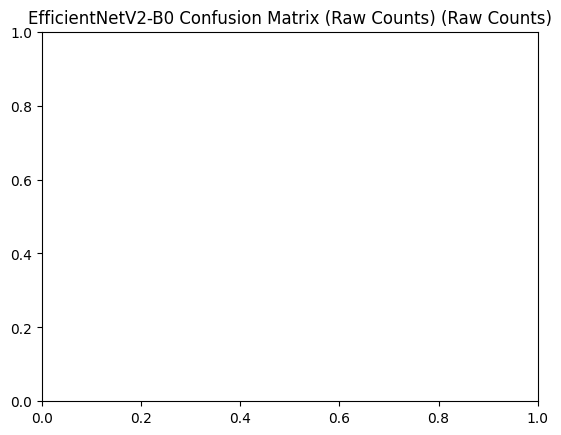

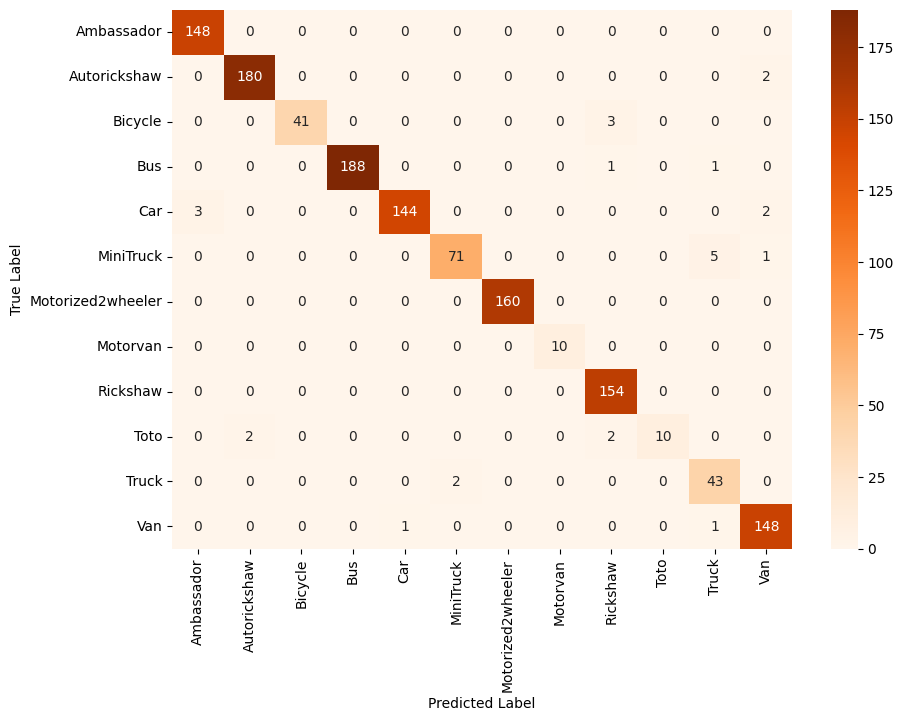

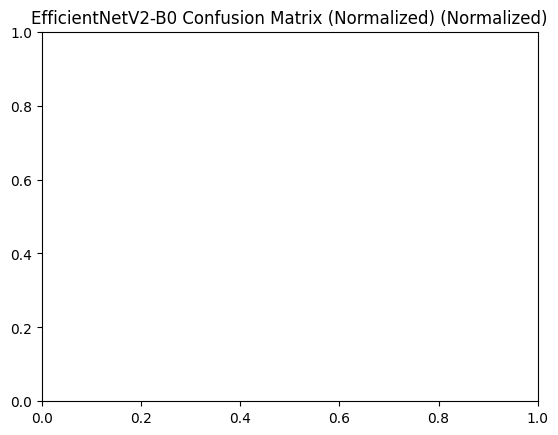

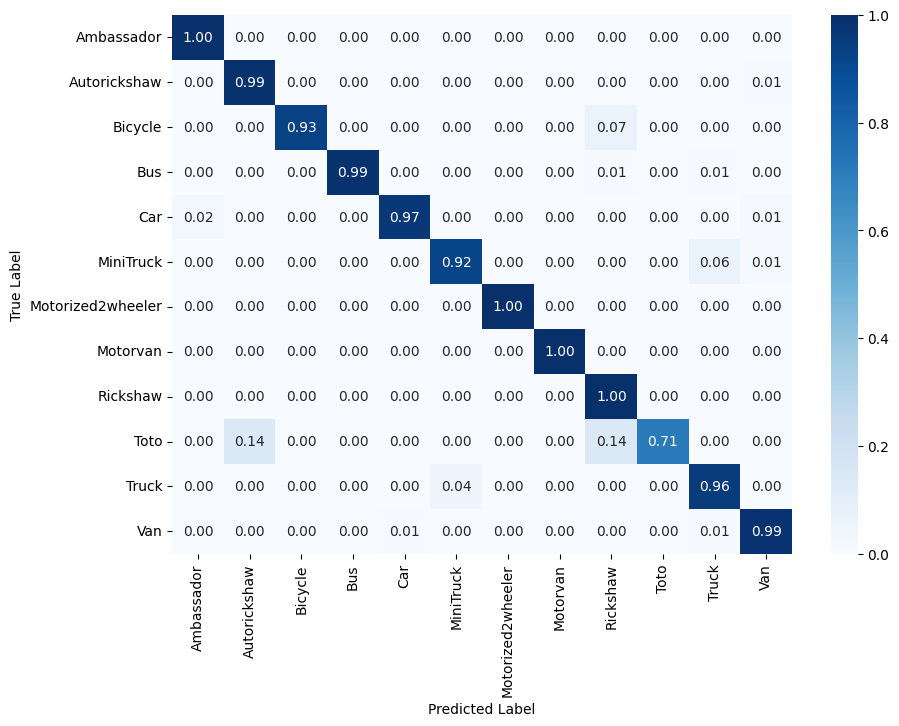

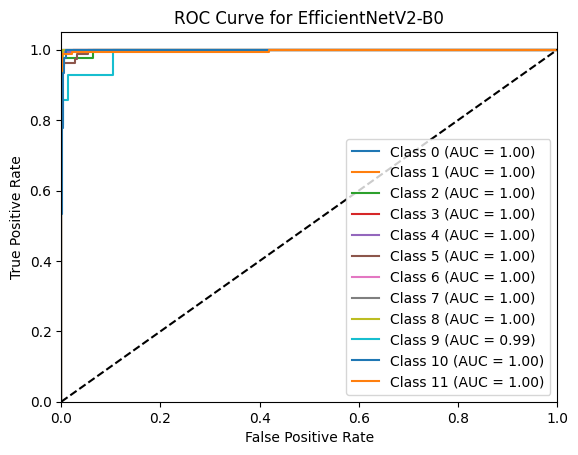

In [17]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

train_model(EfficientNetV2B0, preprocess_input, 'EfficientNetV2-B0', class_names)